In [1]:

##import libraries
from tinyimagenet import TinyImageNet
from pathlib import Path
import torch
from torchvision import models
import pandas as pd
import os
import torch.utils.data as data
#from torchvision.models._api import WeightsEnum
#from torch.hub import load_state_dict_from_url
import numpy as np
import tmeasures as tm
### para mostrar la trasnformacion
from tinyimagenet import TinyImageNet
from torchvision import transforms as T
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

import seaborn as sns
from pylab import *
import sys

sns.set()
#%%

#sys.path.append('./Notebooks/')

/home/tbadaracco/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load transformations
import transformaciones as tr

rotation_transforms = tr.rotation_transforms()
translation_transforms = tr.translation_transforms()
scale_transforms = tr.scale_transforms()
perspective_transforms = tr.perspective_transforms()
brightness_transforms = [tr.brightness_transforms(factor) for factor in tr.brightness_parameters]
contrast_transformations = [tr.contrast_transforms(alpha) for alpha in tr.contrast_list]
grayscale_transformations = [tr.grayscale_transforms(alpha) for alpha in tr.grey_list]
solarize_transformations = [tr.solarize_transforms(threshold) for threshold in tr.solarization_thresholds]
posterize_transformations = [tr.posterize_transforms(alpha) for alpha in tr.posterize_list]
invertion_transformations = [tr.invertion_transforms(alpha) for alpha in tr.invertion_list]


transformation_afin = [rotation_transforms,
                       translation_transforms,
                       scale_transforms,
                       perspective_transforms,
                       brightness_transforms,
                       contrast_transformations,
                       grayscale_transformations,
                       solarize_transformations,
                       posterize_transformations,
                       invertion_transformations]


transformaciones = ['rotacion','traslacion','escala','proyeccion','brillo','contraste','escala_grises','solarizacion','posterizacion','inversion_colores']

print('import transformations')
transformaciones = transformaciones

import transformations


In [3]:
main_directory = os.path.join('Invariance_Results', 'efficientNet_B0','from_scratch')
print(main_directory)

Invariance_Results/efficientNet_B0/from_scratch


# Calcula la invarianza

In [4]:
class TinyImageNet(TinyImageNet):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return x

normalize_transform = T.Compose(
    [
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(TinyImageNet.mean,TinyImageNet.std),
    #random_ts
    ])


dataset_nolabels = TinyImageNet(root="~/.datasets/tinyimagenet/",split="train", transform=normalize_transform)

# Subsample 
N = 1000
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices, _ = train_test_split(np.arange(len(dataset_nolabels)), train_size=N, stratify=dataset_nolabels.targets,random_state=24)
test_inv = Subset(dataset_nolabels, indices)

print(len(test_inv))

1000


In [5]:
#%%
# Definir el modelo y checkpoint
weights = None #models.EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = models.efficientnet_b0(weights=weights)

for param in base_model.parameters():
    param.requires_grad = True

tinyimagenet_classes = 200

base_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(1280, tinyimagenet_classes),
)

model = torch.nn.Sequential(
   #T.Normalize(TinyImageNet.mean,TinyImageNet.std),
    #weights.transforms(),
    base_model,
)

#%%
main_directory = '/home/tbadaracco/models/efficientnet_b0/weights_none'
print(main_directory)
#main_directory = os.path.join(main_directory, 'AWS','v2')
#print(main_directory)

/home/tbadaracco/models/efficientnet_b0/weights_none


In [6]:
# Recorrer las carpetas
for root, dirs, files in os.walk(main_directory):
    # Si el directorio .ipynb_checkpoints está en la lista de directorios, elimínalo
    if '.ipynb_checkpoints' in dirs:
        dirs.remove('.ipynb_checkpoints')
    print(root)
    # Verificar si hay un archivo 'checkpoint_last.ckpt' en la lista de archivos de la carpeta actual
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        model_path = os.path.join(dir_path, 'checkpoint_last.ckpt')
        print("Model Path:", model_path)

        # Definir el folder de resultados para cada combinación de modelo e imagen
        results_folder_original = os.path.join(root, 'Invariance_Results')

        # obtain transformation from directory
        directorio_padre = os.path.dirname(model_path)
        nombre_directorio = os.path.basename(directorio_padre)

        print("Transformacion con la que se entreno: ",nombre_directorio)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        #results_path = Path("~/tm_example_pytorch/").expanduser()
        #results_path.mkdir(parents=True, exist_ok=True)


        # Load the model state dictionary
        checkpoint = torch.load(model_path, map_location=device)


        # If the checkpoint is a state dictionary directly, use it; otherwise, look for the 'state_dict' key
        if 'state_dict' in checkpoint:
            model_state_dict = checkpoint['state_dict']
        else:
            model_state_dict = checkpoint

        # Load the model state dictionary
        model.load_state_dict(model_state_dict)

        model = model.to(device)
        model.eval()


        results_folder = os.path.join('Invariance_Results/efficientNet_B0/from_scratch/' , nombre_directorio)
        
        image_path = os.path.join(results_folder,'imagenes')
        print("Directorio donde se guardan las medidas de invarianza para ", nombre_directorio,": ",results_folder)
        

        # Verificar si el directorio existee
        if not os.path.exists(image_path):
            # Si no existe, crearlo
            os.makedirs(image_path)
            print(f"Se ha creado el directorio '{image_path}'.")

        for transformacion,transf_vector in zip(transformaciones,transformation_afin):
            print("Transformacion con la que se va evaluar: ",transformacion)
            transformations = [  transf_vector[i] for i in range(len(transf_vector))]
            
            ## results path
            #results_folder = 'Resultados de medida de invarianza'
            csv_path = os.path.join(results_folder, transformacion + '.csv')
            
            # Verificar si el archivo CSV ya existe
            if os.path.exists(csv_path):
                print(f"El archivo CSV '{csv_path}' ya existe. Se pasará al siguiente proceso.")
                continue  # Pasa al siguiente proceso sin guardar el archivo CSV


            # Create an ActivationsModule from the vanilla model
            def filter_stochastic(a):
                return not str(a).startswith("StochasticDepth")

            activations_module = tm.pytorch.AutoActivationsModule(model,filter=filter_stochastic)


            # Define options for computing the measure
            options = tm.pytorch.PyTorchMeasureOptions(batch_size=2, num_workers=0,model_device=device,measure_device=device,data_device = 'cpu') #,data_device="cpu"

            # Define the measure and evaluate it
            measure = tm.pytorch.NormalizedVarianceInvariance()

            print('Se definio la medida')

            measure_result:tm.pytorch.PyTorchMeasureResult = measure.eval(test_inv,transformations,activations_module,options)  ## lista de invarianzas de cada capa

            measure_result = measure_result.numpy()
        

            vec_inv = tm.pytorch.PyTorchMeasureResult.per_layer_average(measure_result)

            vec_layer = measure_result.layer_names

            df_act = pd.DataFrame({'layer_name' : vec_layer,'inv_avg':vec_inv})

            df_act.to_csv(csv_path,index= False)
            print(f'Se guardo el csv en {csv_path}')


/home/tbadaracco/models/efficientnet_b0/weights_none
Model Path: /home/tbadaracco/models/efficientnet_b0/weights_none/proyeccion/checkpoint_last.ckpt
Transformacion con la que se entreno:  proyeccion
cuda
Directorio donde se guardan las medidas de invarianza para  proyeccion :  Invariance_Results/efficientNet_B0/from_scratch/proyeccion
Transformacion con la que se va evaluar:  rotacion
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/proyeccion/rotacion.csv' ya existe. Se pasará al siguiente proceso.
Transformacion con la que se va evaluar:  traslacion
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/proyeccion/traslacion.csv' ya existe. Se pasará al siguiente proceso.
Transformacion con la que se va evaluar:  escala
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/proyeccion/escala.csv' ya existe. Se pasará al siguiente proceso.
Transformacion con la que se va evaluar:  proyeccion
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scra

3it [09:26, 188.94s/it]                       0.49s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/rotacion.csv
Transformacion con la que se va evaluar:  traslacion
Se definio la medida


3it [09:27, 189.16s/it]                       0.96s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/traslacion.csv
Transformacion con la que se va evaluar:  escala
Se definio la medida


3it [09:26, 188.98s/it]                       0.56s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/escala.csv
Transformacion con la que se va evaluar:  proyeccion
Se definio la medida


3it [09:27, 189.05s/it]                       0.62s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/proyeccion.csv
Transformacion con la que se va evaluar:  brillo
Se definio la medida


3it [09:26, 188.84s/it]                       0.56s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/brillo.csv
Transformacion con la que se va evaluar:  contraste
Se definio la medida


3it [09:27, 189.10s/it]                       0.81s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/contraste.csv
Transformacion con la que se va evaluar:  escala_grises
Se definio la medida


3it [09:26, 188.83s/it]                       0.35s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/escala_grises.csv
Transformacion con la que se va evaluar:  solarizacion
Se definio la medida


3it [09:27, 189.16s/it]                       0.64s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/solarizacion.csv
Transformacion con la que se va evaluar:  posterizacion
Se definio la medida


3it [09:27, 189.09s/it]                       0.81s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/posterizacion.csv
Transformacion con la que se va evaluar:  inversion_colores
Se definio la medida


3it [09:27, 189.24s/it]                       0.85s/it]


Se guardo el csv en Invariance_Results/efficientNet_B0/from_scratch/contraste/inversion_colores.csv
Model Path: /home/tbadaracco/models/efficientnet_b0/weights_none/without_transformation/checkpoint_last.ckpt
Transformacion con la que se entreno:  without_transformation
cuda
Directorio donde se guardan las medidas de invarianza para  without_transformation :  Invariance_Results/efficientNet_B0/from_scratch/without_transformation
Transformacion con la que se va evaluar:  rotacion
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/without_transformation/rotacion.csv' ya existe. Se pasará al siguiente proceso.
Transformacion con la que se va evaluar:  traslacion
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/without_transformation/traslacion.csv' ya existe. Se pasará al siguiente proceso.
Transformacion con la que se va evaluar:  escala
El archivo CSV 'Invariance_Results/efficientNet_B0/from_scratch/without_transformation/escala.csv' ya existe. Se pasará al s

In [4]:
def clean_df(df):

    df['layer_name'] = df['layer_name'].str.replace('/EfficientNet_0/features/','')
    df['layer_name'] = df['layer_name'].str.replace('/EfficientNet_0/','')

    sep='/'
    s=df.layer_name.str.count(sep)
    df_layer_split=((s.max()-s).map(lambda x : x*sep)+df.layer_name).str.split(sep,expand=True)

    df_layer_split.loc[df_layer_split[4] == 'Normalize_0',0] = 'Normalization'

    df_layer_split.loc[(df_layer_split[3] == 'Conv2dNormActivation_0') & (df_layer_split[0] == ''),0] = 'Sequential_0'
    df_layer_split.loc[(df_layer_split[3] == 'Conv2dNormActivation_8') & (df_layer_split[0] == ''),0] = 'Sequential_8'
    df_layer_split.loc[df_layer_split[3] == 'classifier',0] = 'Sequential_8'
    df_layer_split.loc[(df_layer_split[4] == 'avgpool') & (df_layer_split[0] == ''),0] = 'Sequential_8'
    df_layer_split.loc[(df_layer_split[3]== '') & (df_layer_split[0] == 'Sequential_8'),3] = 'pre-classifier'

    #print(df_layer_split.shape)
    df_layer_split = df_layer_split.loc[df_layer_split[0] != ''] 
    #print(df_layer_split.shape)


    cat_layer_order = CategoricalDtype(
        ['Normalize_0','Conv2d_0', 'BatchNorm2d_1', 'SiLU_2', 'avgpool', 'fc1','activation', 'fc2', 'scale_activation', 'Dropout_0', 'Linear_1'],
    ordered=True
    )

    cat_layer_order_2 = CategoricalDtype(
        ['Normalization', 'Conv2dNormActivation_0', 'Conv2dNormActivation_1', 'SqueezeExcitation_1', 'SqueezeExcitation_2', 'Conv2dNormActivation_2', 'Conv2dNormActivation_3', 'Conv2dNormActivation_8', 'pre-classifier', 'classifier'],
        ordered=True
    )

    # Convertir columnas al tipo categórico
    df_layer_split[4] = df_layer_split[4].astype(cat_layer_order)
    df_layer_split[3] = df_layer_split[3].astype(cat_layer_order_2)
    
    df_layer_split.sort_values(by = [0,1,2,3,4], inplace = True)

    df_layer_split.rename(columns={0:'Sequential'},inplace=True)

    df_join = pd.concat([df.loc[:,['layer_name', 'inv_avg']], df_layer_split], axis=1)


    df_join.sort_values(by = ['Sequential',1,2,3,4], inplace = True)
    df_join.reset_index(inplace=True,drop=True)

    df_join['layer'] = df_join[4].str.split('_').str[0]
    df_join['layer'] = df_join['layer'] + '_' + df_join.index.astype(str)
    df_join = df_join.loc[~df_join.Sequential.isna()]
    df_join.reset_index(inplace=True,drop=True)
    #print(df_join.shape)
    
    return df_join



In [5]:
main_directory = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch'
for root, dirs, files in os.walk(main_directory):
    for file in files:
        if file.endswith(".csv") and 'clean' not in file:
            file_path = os.path.join(root, file)
            print(file_path)
            # Leer el archivo CSV
            df = pd.read_csv(file_path)
            #print(df.head())
            # Limpiar el DataFrame
            df_clean = clean_df(df)
            # Obtener el nombre del archivo sin la extensión
            file_name, file_ext = os.path.splitext(file)
            # Construir el nuevo nombre de archivo con "_clean" añadido antes de la extensión
            new_file_name = f"{file_name}_clean{file_ext}"
            # Construir la ruta de destino para guardar el archivo CSV limpio
            csv_path = os.path.join(root, new_file_name)
            # Guardar el DataFrame limpio como un nuevo archivo CSV
            df_clean.to_csv(csv_path, index=False)
            print(f'Se guardó el archivo CSV limpio en {csv_path}')
            #aplico el primer grafico


/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/df_complete.csv
Se guardó el archivo CSV limpio en /home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/df_complete_clean.csv
/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/escala_grises.csv
Se guardó el archivo CSV limpio en /home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/escala_grises_clean.csv
/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/solarizacion.csv
Se guardó el archivo CSV limpio en /home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/solarizacion_clean.csv
/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/rotacion.csv
Se guardó el archivo CSV limpio en /home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/rotacion_clean.csv
/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/proyeccion/posterizacion.csv
Se guardó el archivo CSV lim

In [3]:
def grafico_completo(df_join,entrenado_transformacion,transformacion):
    
    #cmap = plt.cm.get_cmap('plasma', 9)    # PiYG
    cmap = plt.colormaps['plasma'].resampled(9)
    color = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba

        color.append(matplotlib.colors.rgb2hex(rgba))

    df_join = df_join.iloc[1:,:]
    df_join.reset_index(inplace = True,drop=True)
    keys = df_join['Sequential'].unique()
    colours =  dict(zip(keys, color))


    plt.figure(figsize=(35,8))
    for i in range(len(df_join)-1):
        x = df_join['layer'][i], df_join['layer'][i+1]
        y = df_join['inv_avg'][i], df_join['inv_avg'][i+1]
        c = colours[df_join['Sequential'][i]]
        ax = sns.lineplot(x=x, y=y,color = c,linewidth = 5)
        mod_layer = df_join['layer'].str.split('_').str[0]
        ax.set(xlim=(0, 15))
        ax.set_xticks(range(len(df_join)), labels=mod_layer)
        ax.tick_params(axis='x', rotation=90 ,which='major', pad=15)
        ax.set_xlabel("Capas")
        ax.set_ylabel("Varianza Normalizada")
        ax.set_title(f'Invarianza por capa EfficientNetB0 re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}')

    # Obtener la figura actual y guardarla en una variable
    fig = plt.gcf()
    return fig


/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya existe, paso al siguiente
El gráfico ya e

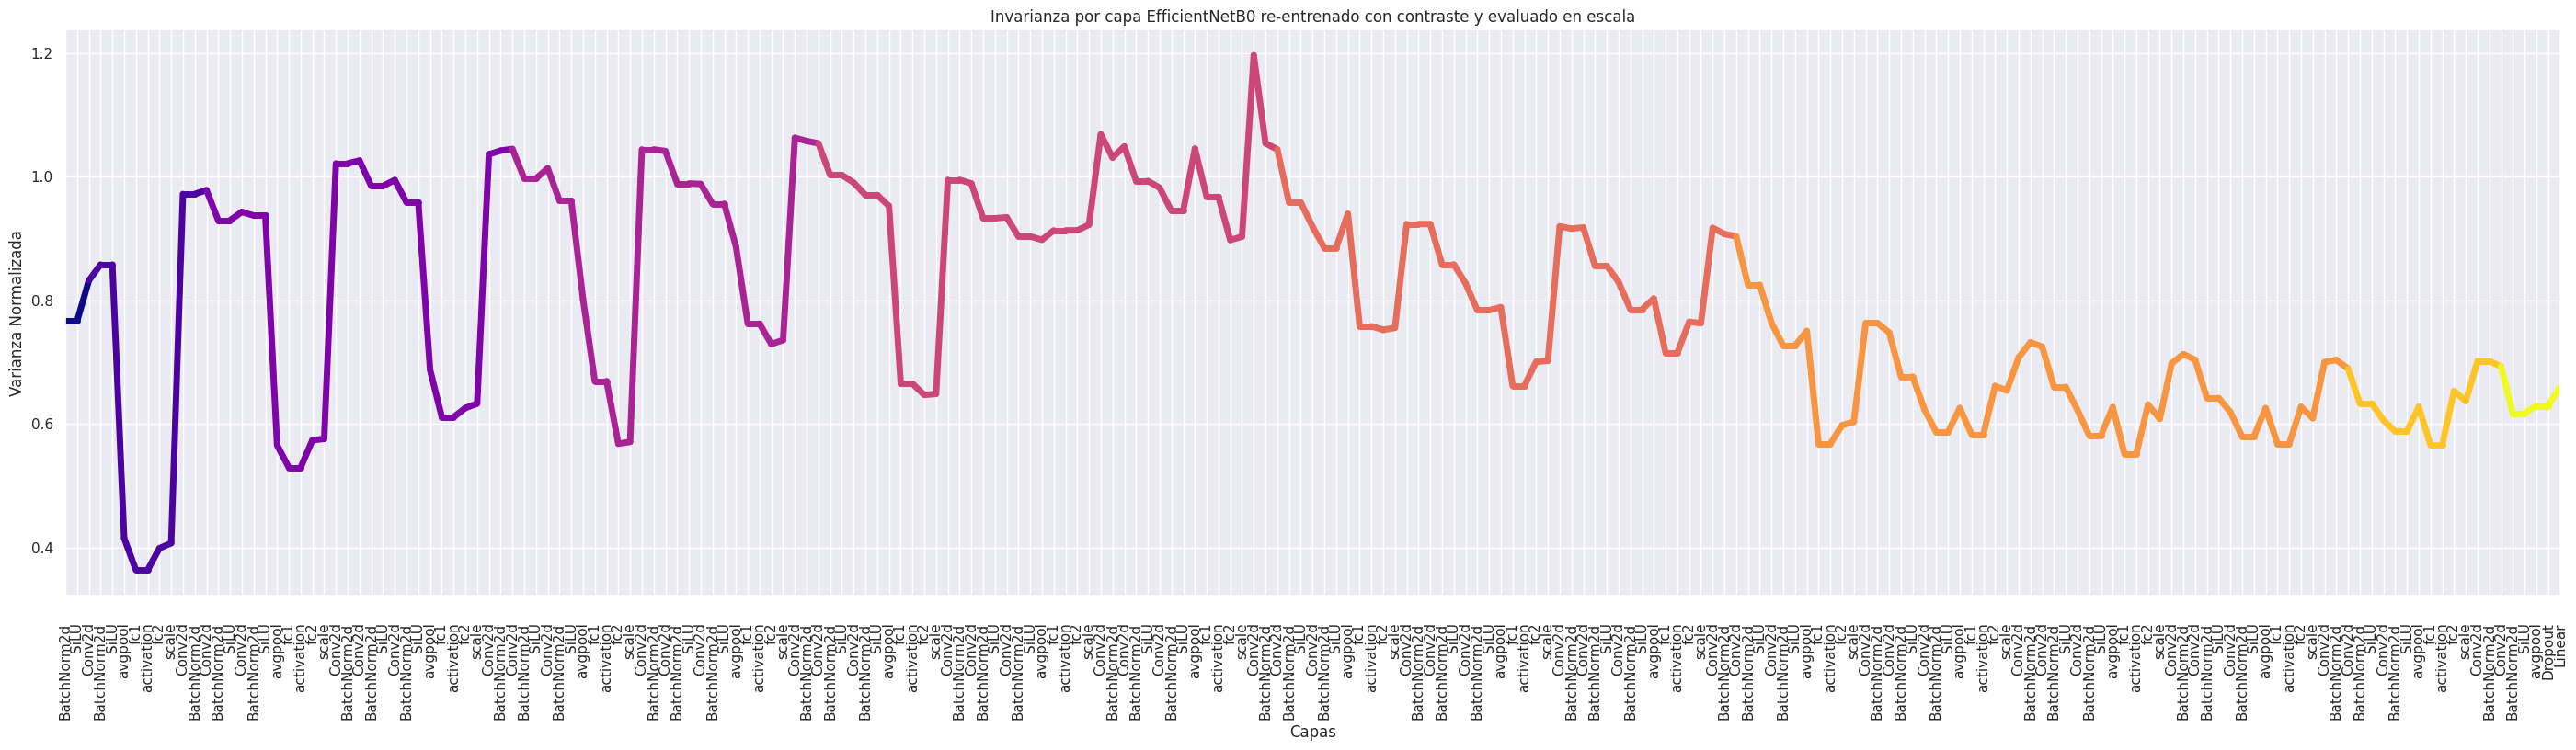

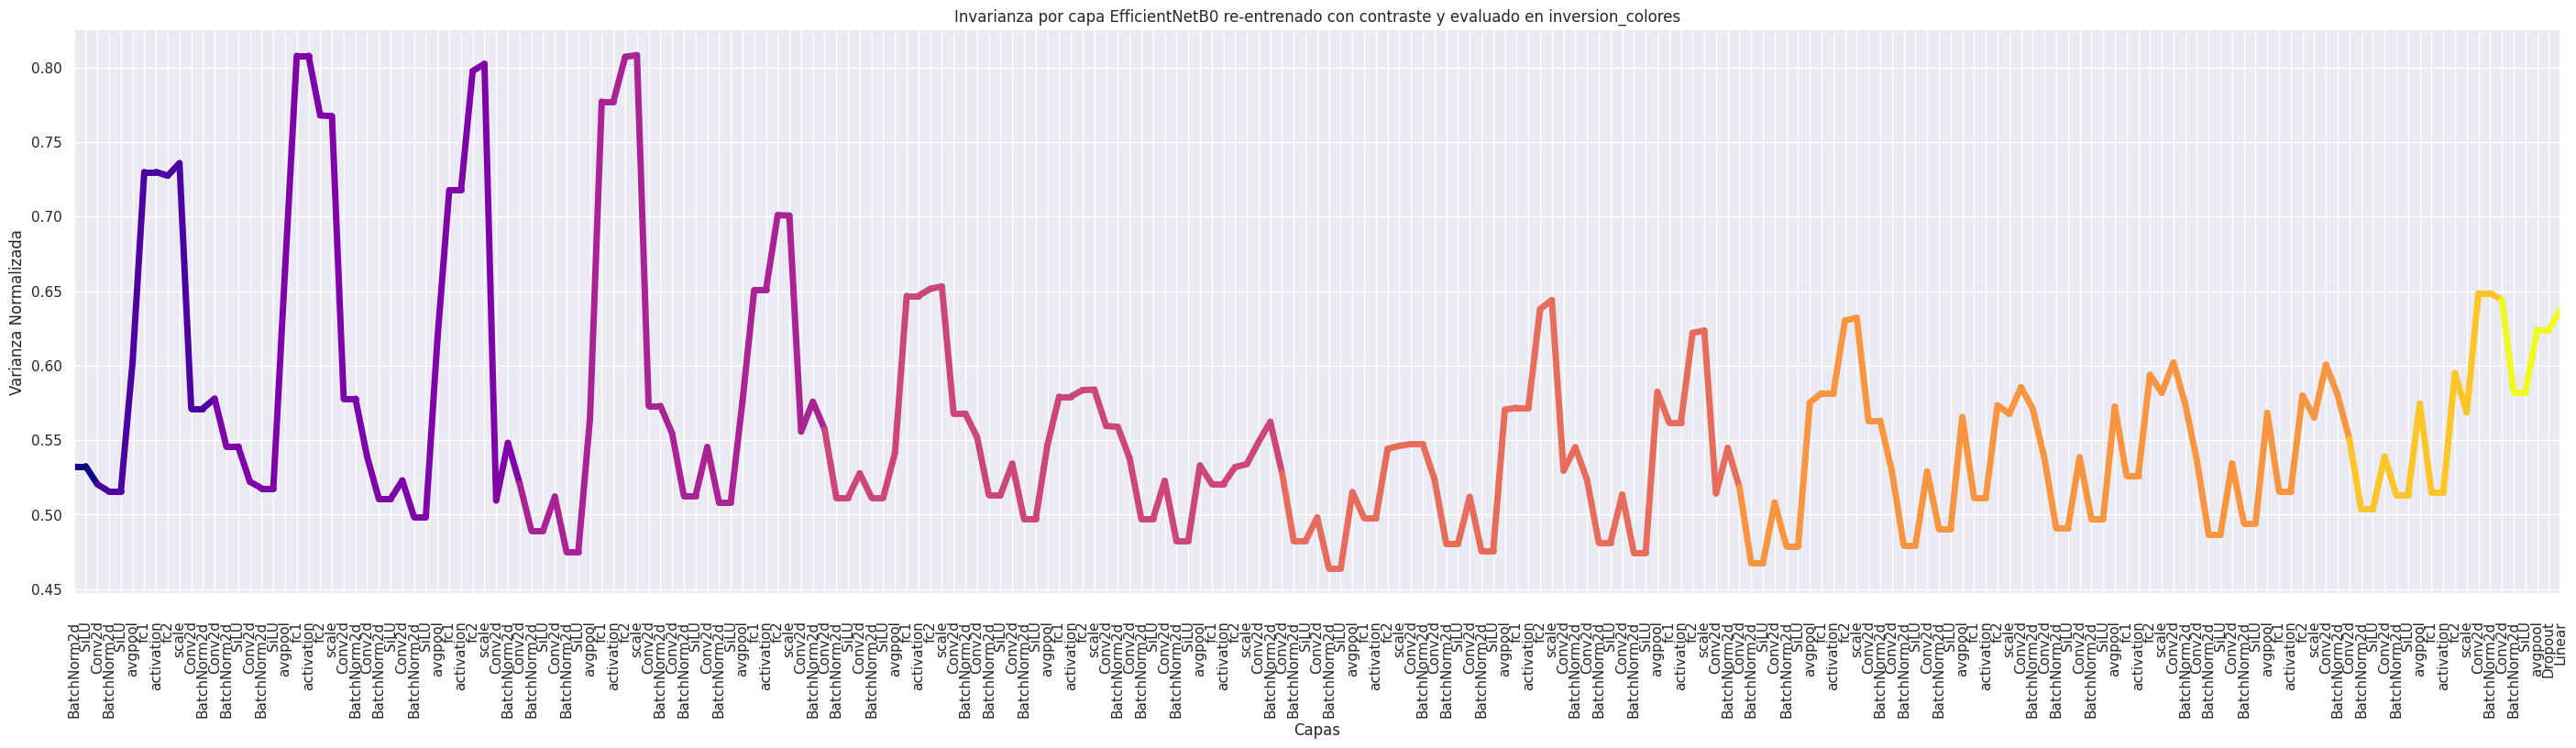

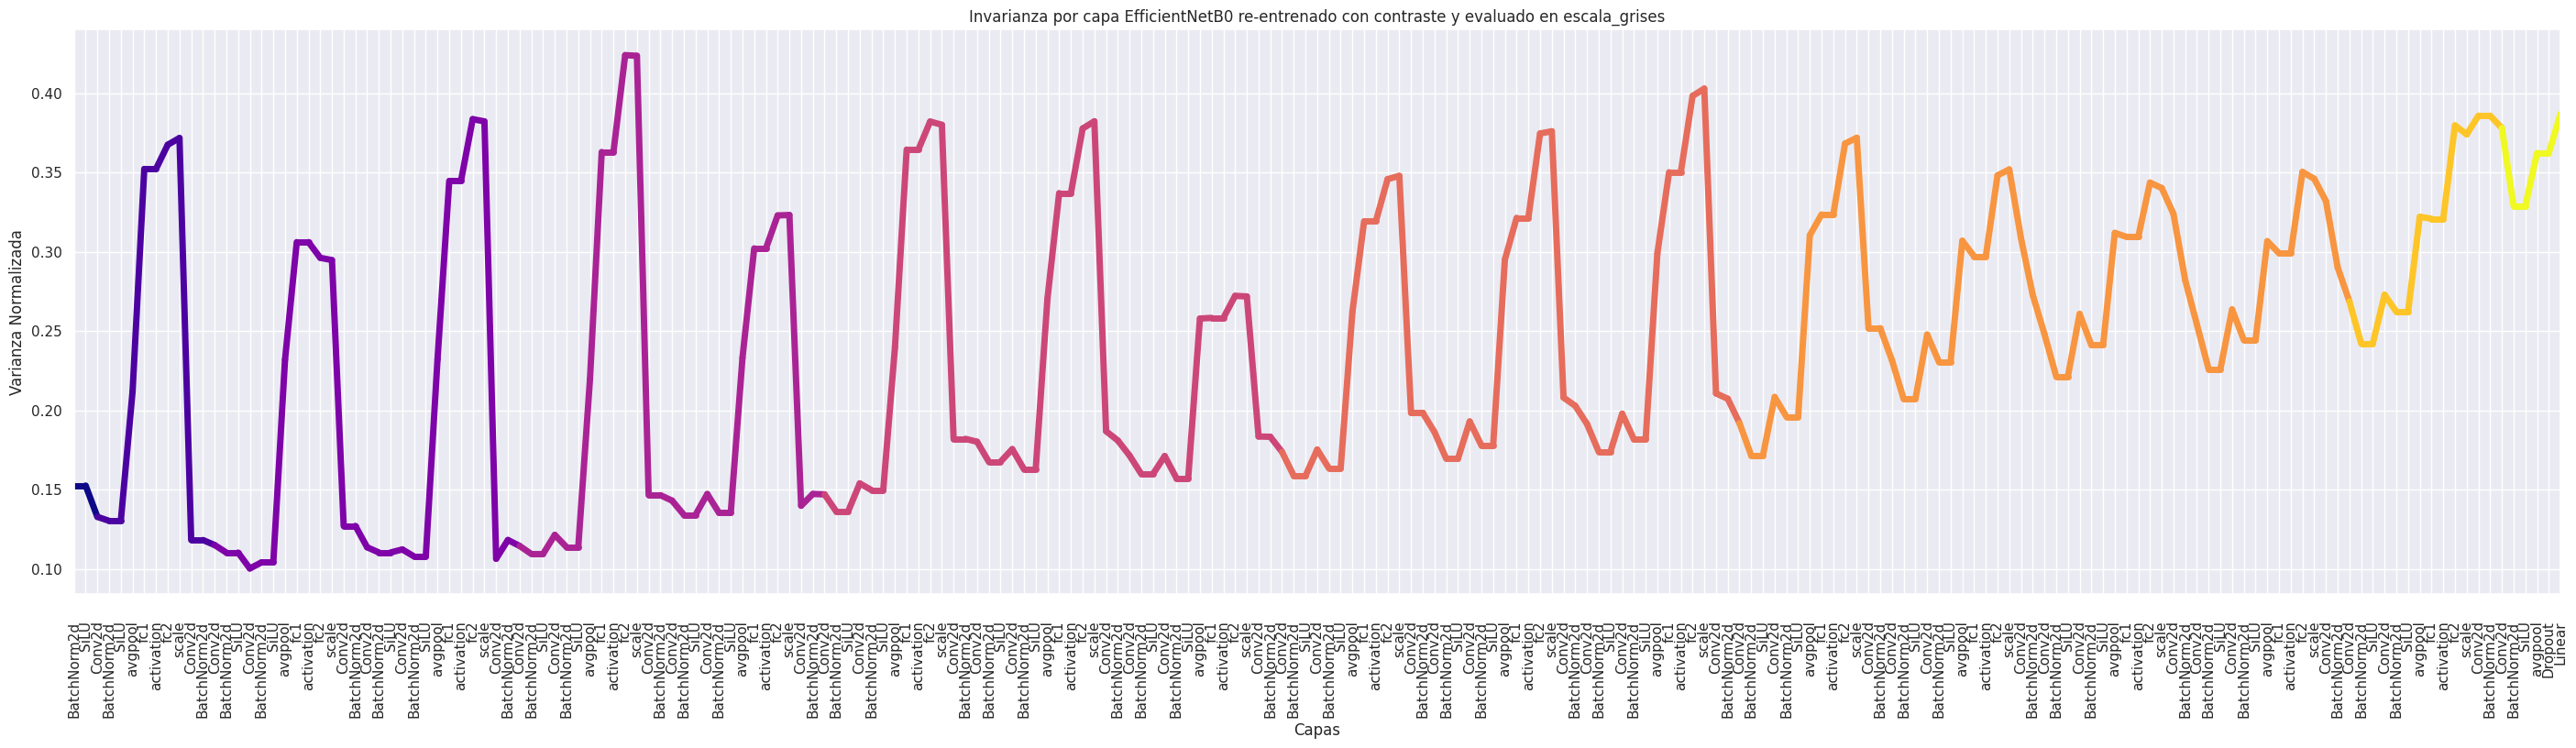

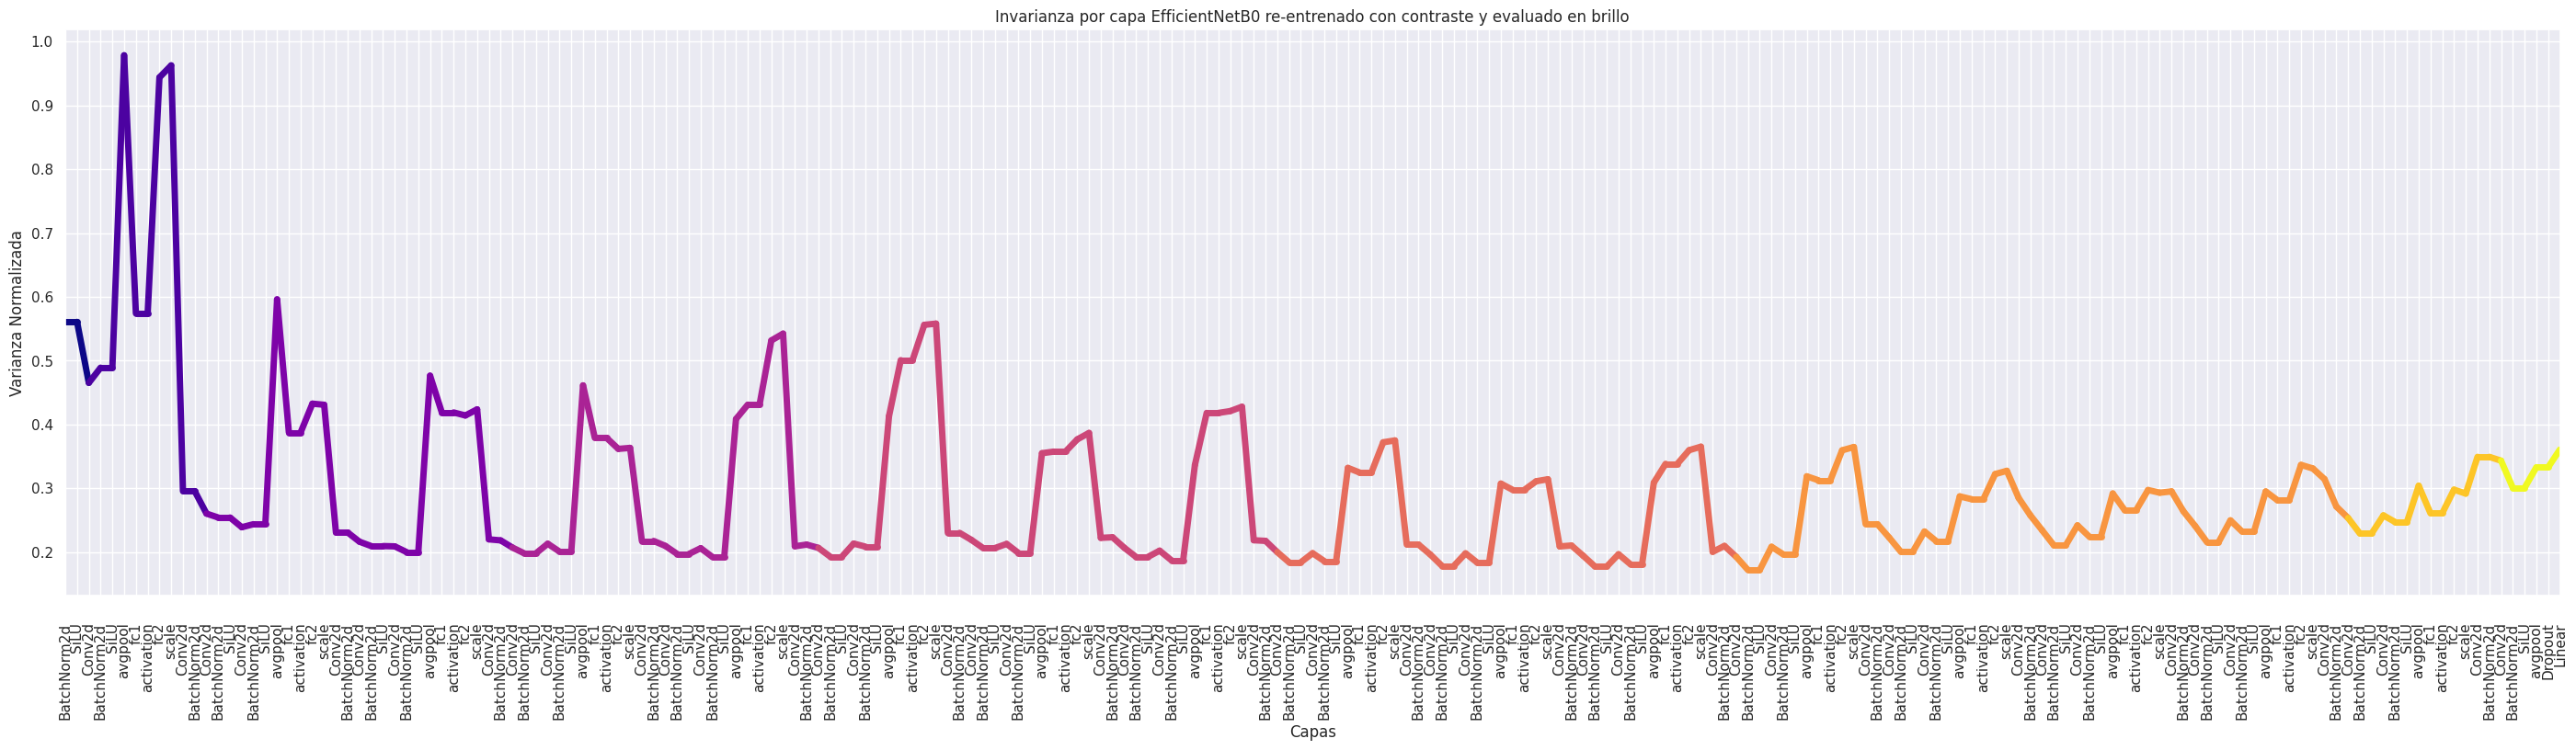

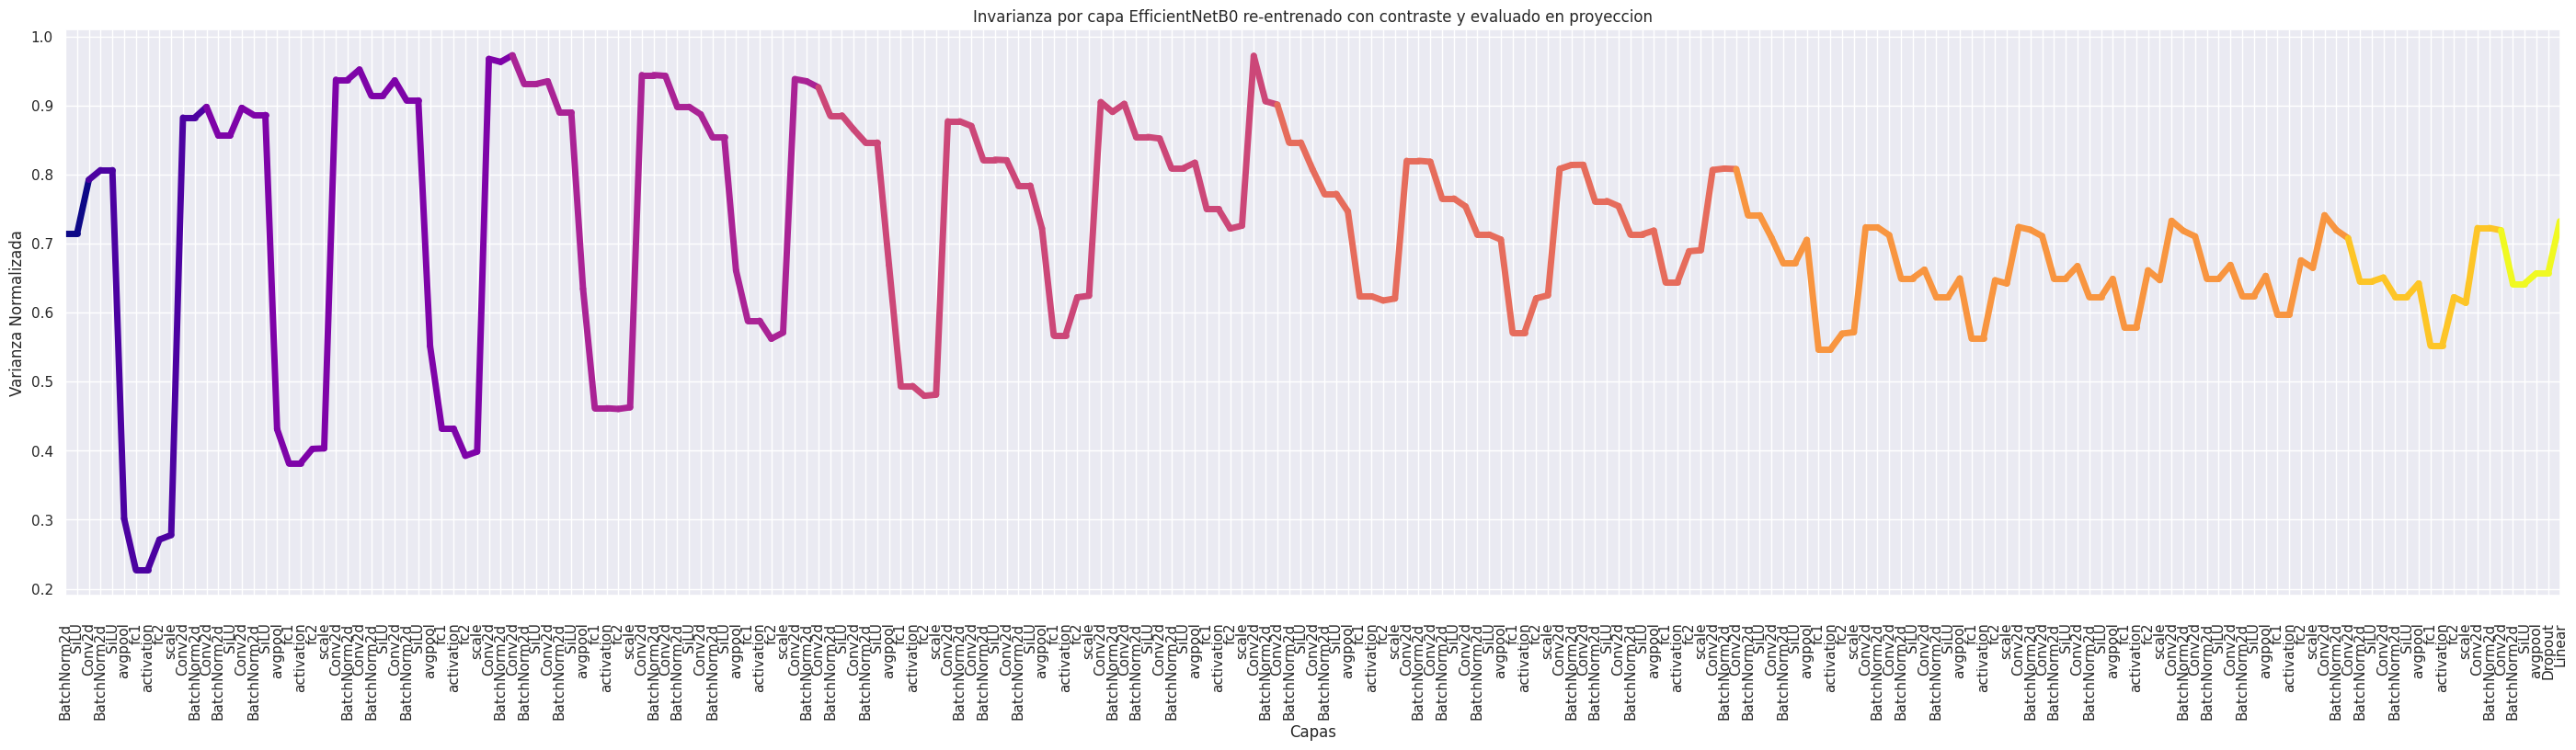

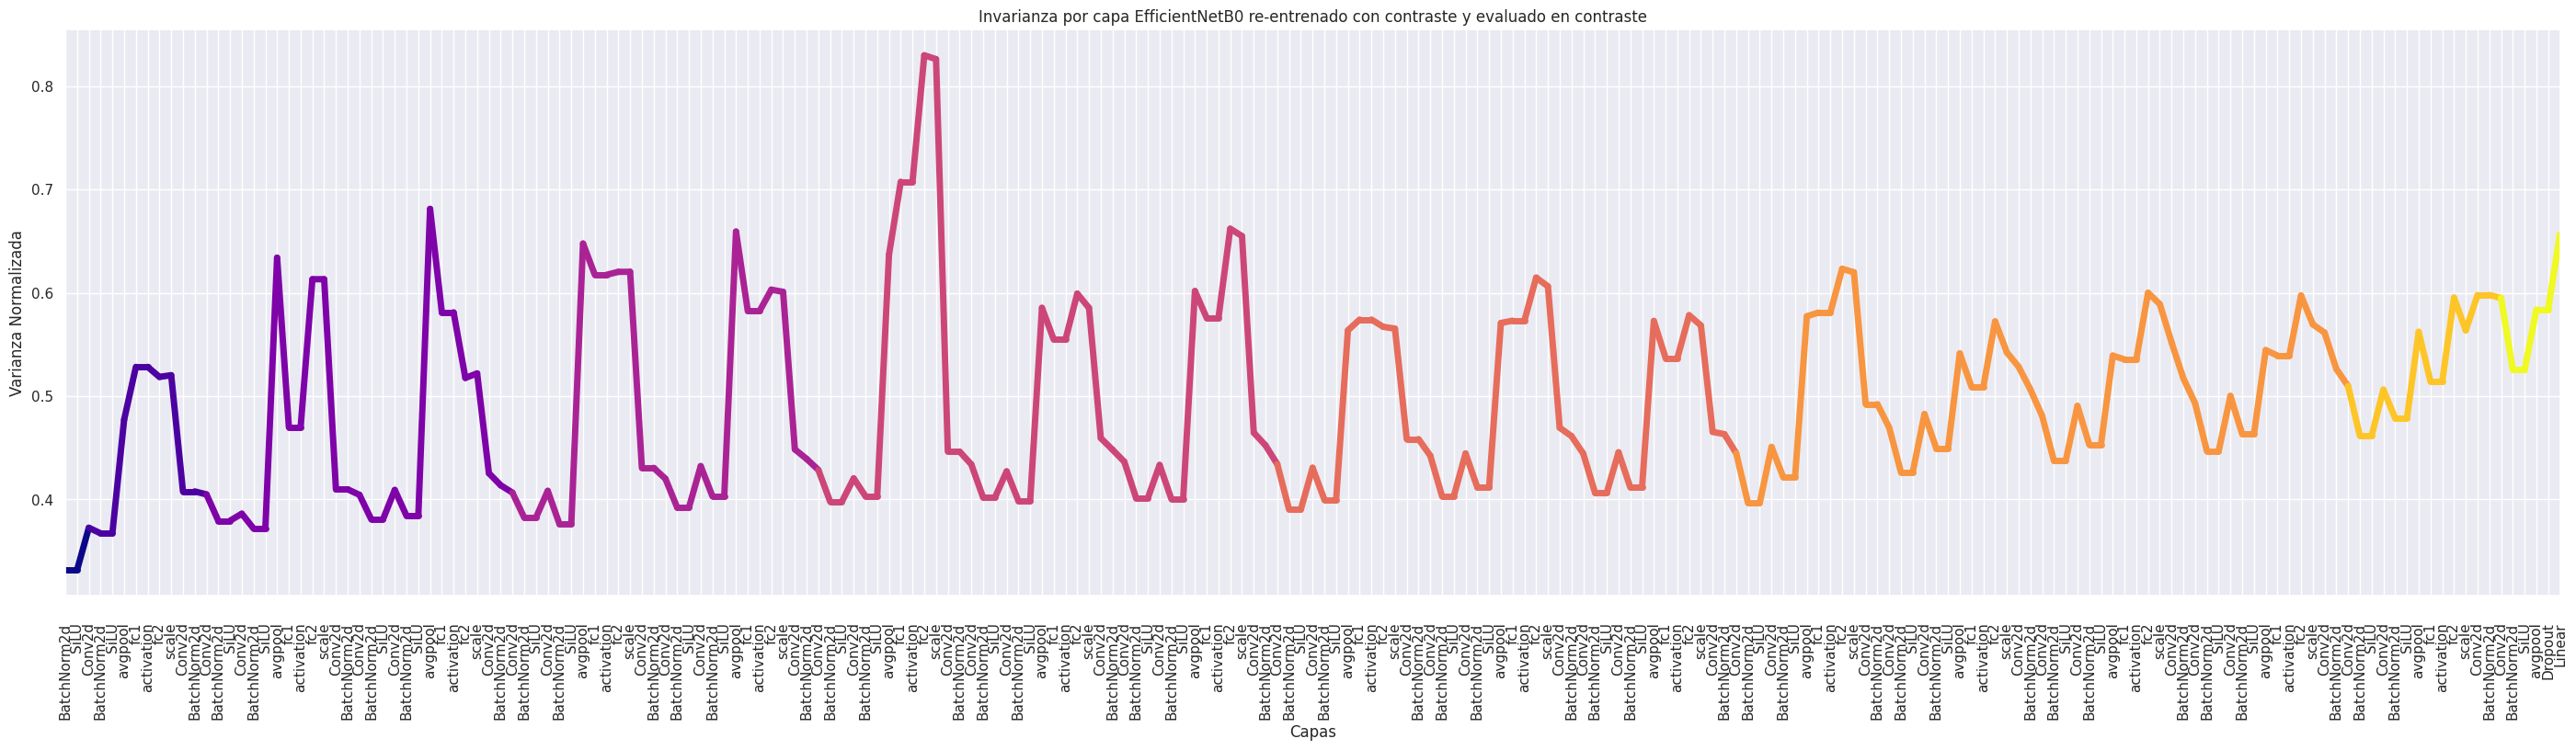

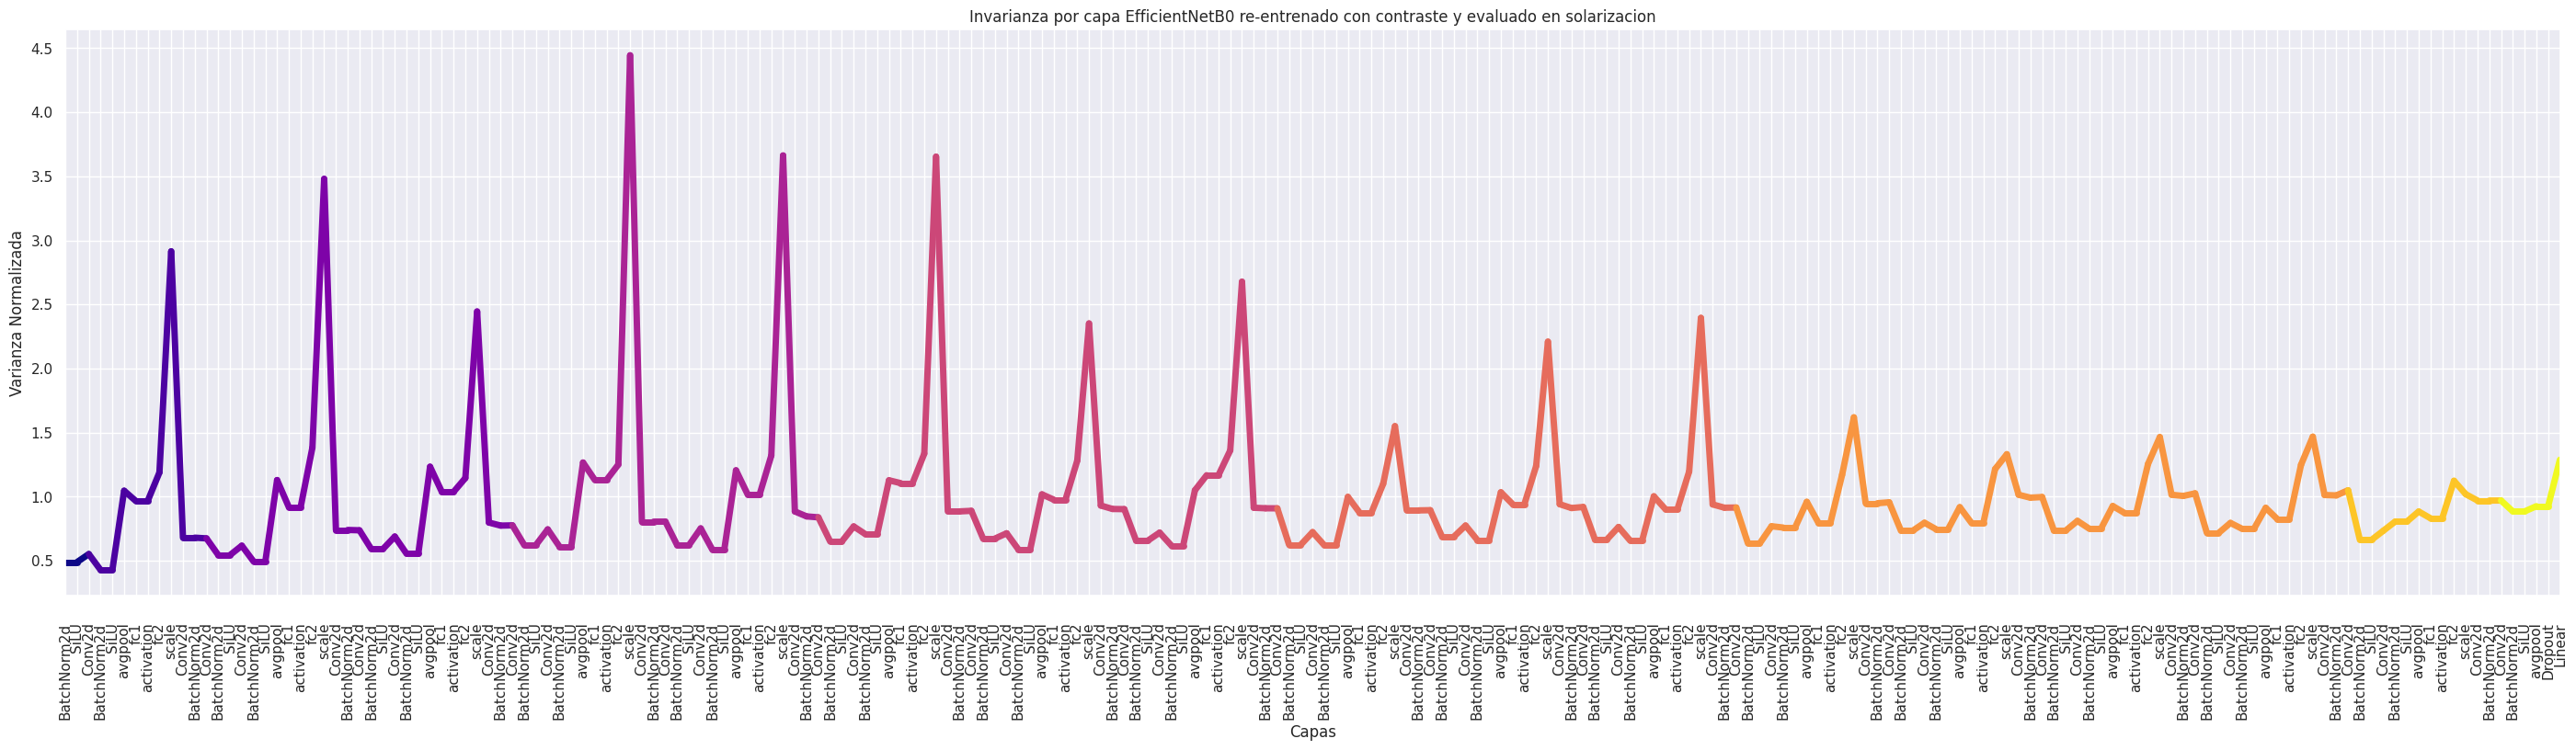

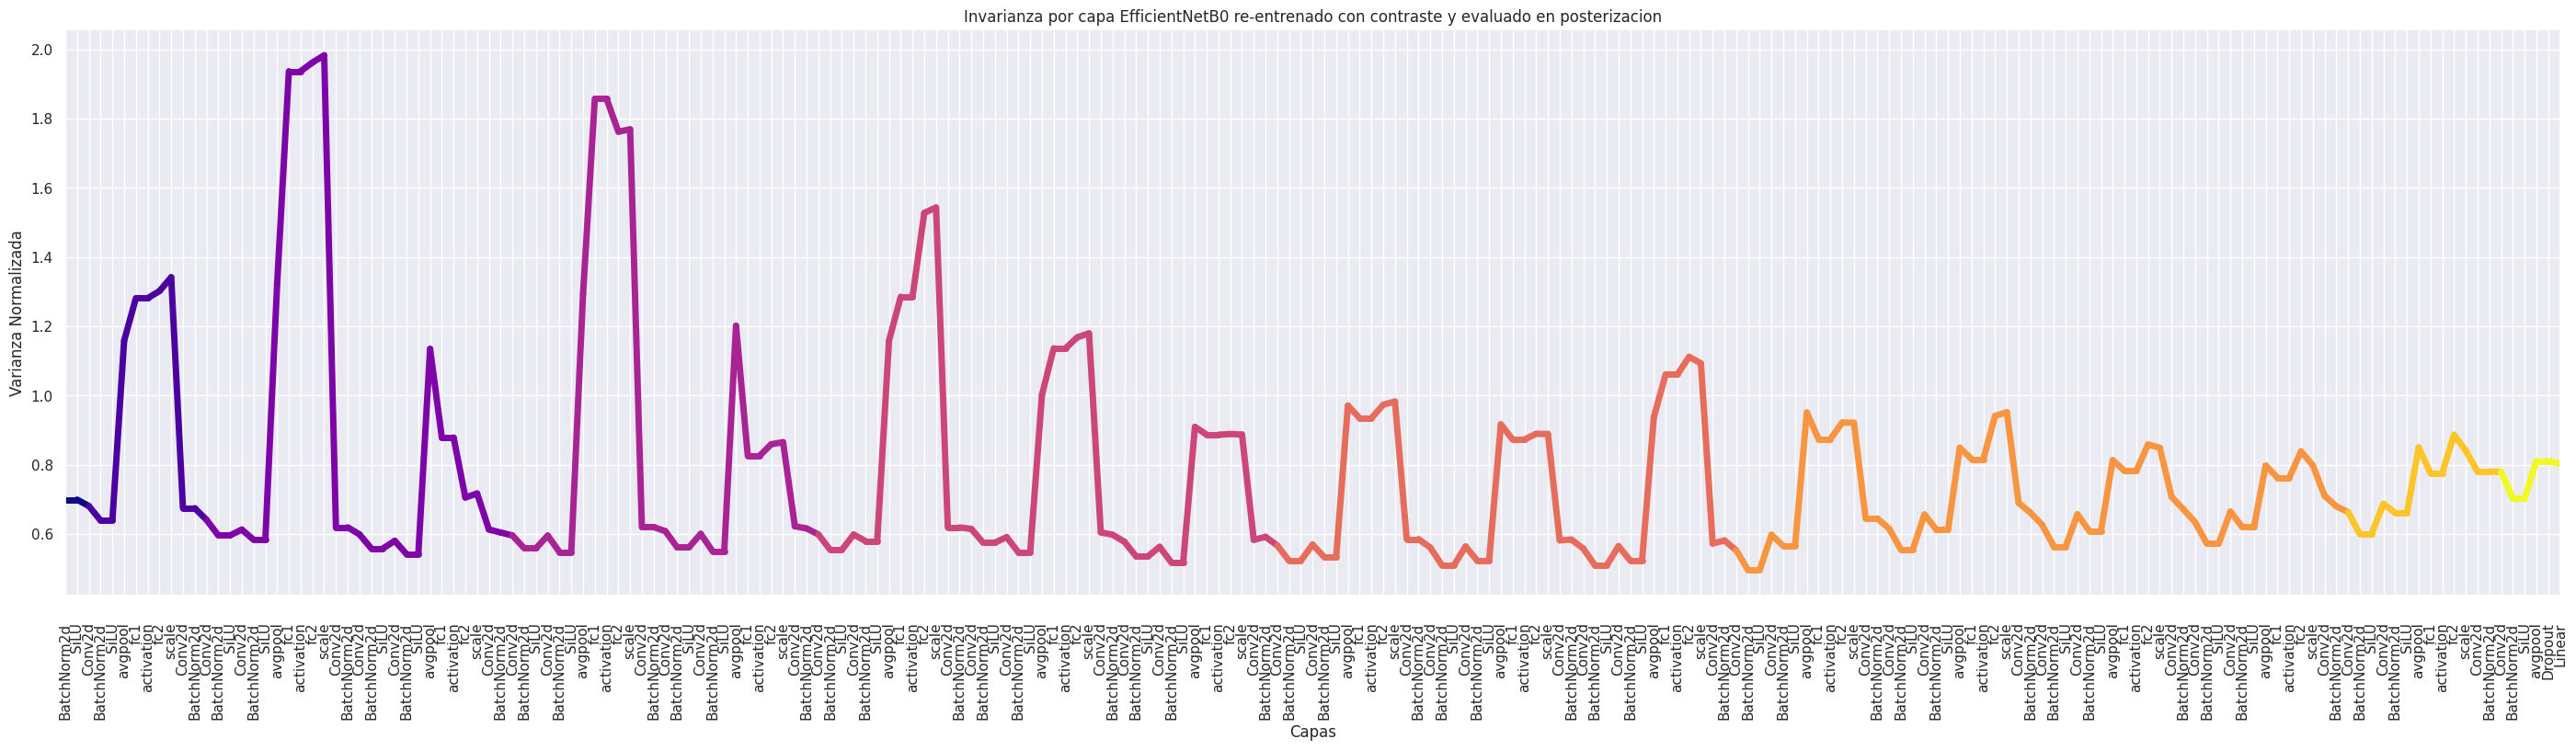

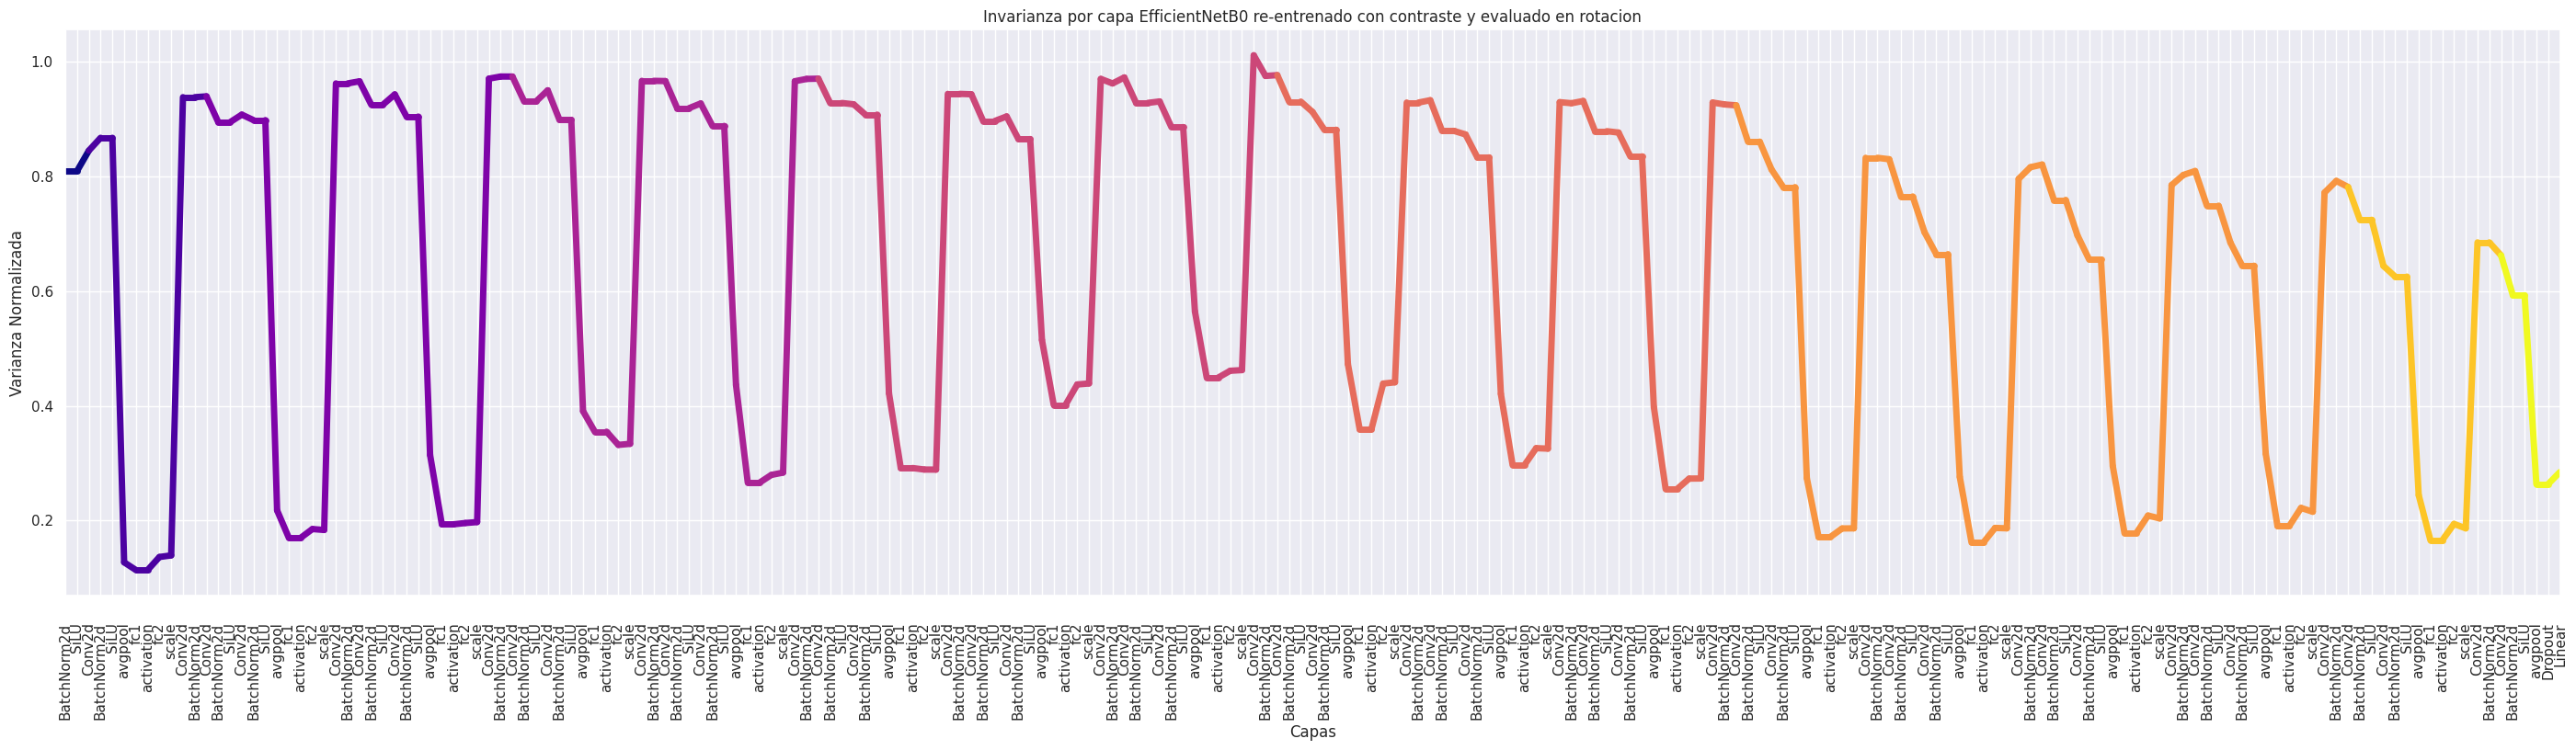

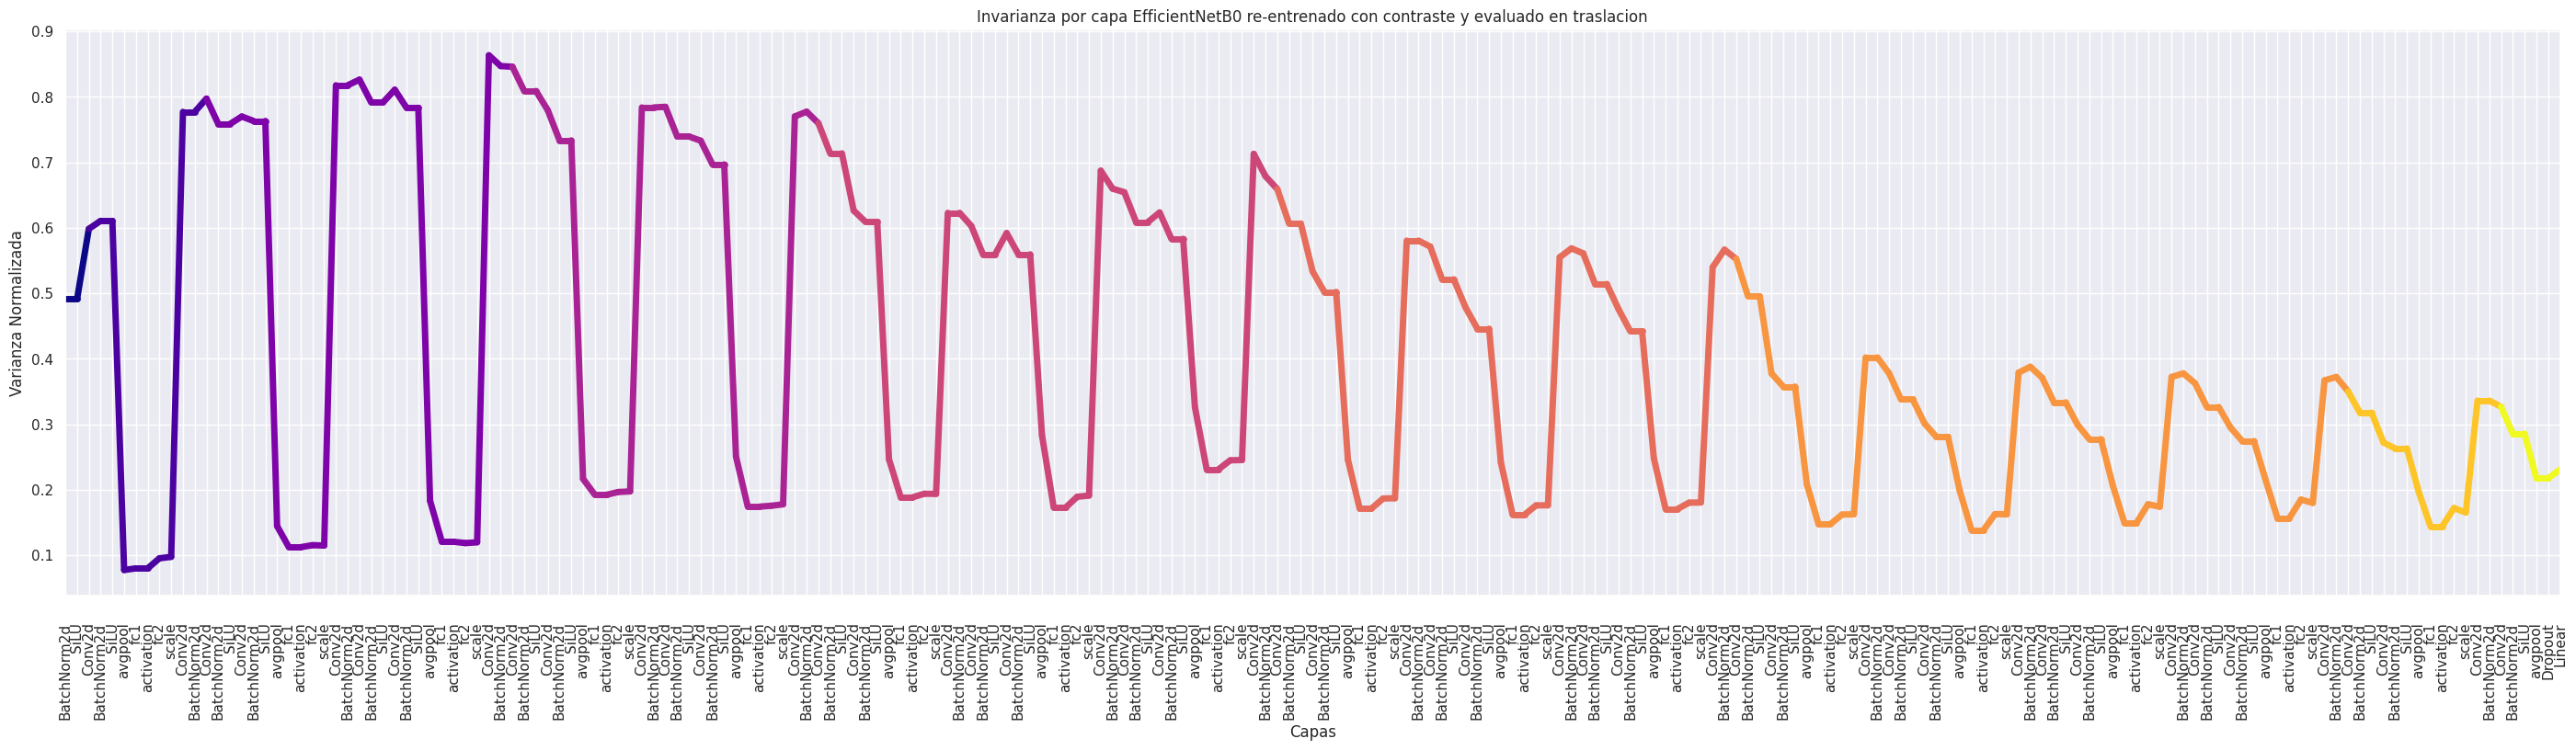

In [4]:
main_directory = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch'
print(main_directory)
## Aplico primer gráfico
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(sub_root, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)

                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)

                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(sub_root, 'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_1.png')
                    if os.path.exists(imagen_path):
                        print("El gráfico ya existe, paso al siguiente")
                        continue

                    # Crear gráfico
                    fig = grafico_completo(df, nombre_directorio, file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [5]:
cmap = plt.colormaps['plasma'].resampled(9)    # PiYG
color = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    color.append(matplotlib.colors.rgb2hex(rgba))

In [6]:
def grafico_por_estados(df_join,entrenado_transformacion,transformacion):
    
    df_join = df_join.iloc[1:,:]
    df_join.reset_index(inplace = True,drop=True)
    keys = df_join['Sequential'].unique()
    colours =  dict(zip(keys, color))
    #  Categorical Data
    a = 3  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(20,8))

    for seq in df_join.Sequential.unique():
        plt.subplot(a, b, c)
        df = df_join.loc[df_join.Sequential == seq,]
        col = colours[seq]
        g = sns.lineplot(data = df, x='layer', y='inv_avg',color = col,linewidth = 2,marker = 'o')
        mod_layer = df['layer'].str.split('_').str[0]
        #g.set(xlim=(0, 15))
        g.set_xticks(range(len(df)), labels=mod_layer)
        g.tick_params(axis='x', rotation=90 )
        c = c + 1
        plt.xticks(df['layer'][::1])
        g.set_xlabel("Capas")
        g.set_ylabel("Varianza Normalizada")
        titulo = 'Estado ' + str(c - 1)
        plt.title(titulo)
        titulo_general = f'Invarianza por capa con transformación re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}'
        plt.suptitle(titulo_general, fontsize=16)
        plt.tight_layout()

    fig = plt.gcf()
    return fig

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        #print(dir_path)
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                #print(file)
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_2.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    #creo grafico
                    fig = grafico_por_estados(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [13]:
#  quito los bloques SE para analizar la varianza sin esos bloques xq no son secuenciales
bloque_se = ['avgpool',
'fc1',
'activation',
'fc2',
'scale_activation']

In [14]:
def grafico_sinbloqueSE_completo(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    print(df.shape)

    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))


    plt.figure(figsize=(35,8))
    for i in range(len(df)-1):
        x = df['layer'][i], df['layer'][i+1]
        y = df['inv_avg'][i], df['inv_avg'][i+1]
        c = colours[df['Sequential'][i]]
        ax = sns.lineplot(x=x, y=y,color = c,linewidth = 5,marker = 'o')
        mod_layer = df['layer'].str.split('_').str[0]
        ax.set(xlim=(0, 15))
        ax.set_xticks(range(len(df)), labels=mod_layer)
        ax.tick_params(axis='x', rotation=90 ,which='major', pad=15)
        ax.set_xlabel("Capas")
        ax.set_ylabel("Varianza Normalizada")
        ax.set_title(f'Invarianza por capa EfficientNetB0 sin bloques SE y re-entrenado con {entrenado_transformacion} y evaluado en {transformacion}')

    fig = plt.gcf()
    return fig
        #plt.savefig(os.path.join(image_path , 'invarianza sin bloque SE-' + transformacion + '.png'))

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                #print(files)
        
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_3.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    #creo grafico
                    fig = grafico_sinbloqueSE_completo(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [17]:
def grafico_sinbloqueSE_estado(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    
    print(df.shape)


    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))
        #  Categorical Data
    a = 3  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(20,10))

    for seq in df.Sequential.unique():
        plt.subplot(a, b, c)
        df_fil = df.loc[df.Sequential == seq,]
        col = colours[seq]
        g = sns.lineplot(data = df_fil, x='layer', y='inv_avg',color = col,linewidth = 2,marker = 'o')
        mod_layer = df_fil['layer'].str.split('_').str[0]
        #g.set(xlim=(0, 15))
        g.set_xticks(range(len(df_fil)), labels=mod_layer)
        g.tick_params(axis='x', rotation=90 )
        c = c + 1
        plt.xticks(df_fil['layer'][::1])
        g.set_xlabel("Capas")
        g.set_ylabel("Varianza Normalizada")
        titulo = 'Estado ' + str(c - 1)
        plt.title(titulo)
        titulo_general = f'Invarianza por capa EfficienNetB0 sin bloques SE re-entrenado con transformación {entrenado_transformacion} y evaluado con {transformacion}'
        plt.suptitle(titulo_general, fontsize=16)
    
    plt.tight_layout()

    fig = plt.gcf()
    return fig

In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_4.png')
                    fig = grafico_sinbloqueSE_estado(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

In [20]:
def grafico_boxplot(df_join,entrenado_transformacion,transformacion):
    df1 = df_join.loc[~(df_join['4'].isin(bloque_se))]
    df2 = df_join.loc[(df_join['4'].isin(bloque_se)) & (df_join.Sequential == 'Sequential_8')]
    df = pd.concat([df1,df2],axis = 0)
    df = df.loc[df.Sequential != 'Normalization',]
    df.reset_index(inplace=True,drop=True)
    

    plt.figure(figsize=(10, 6))
    ##boxplot
    df['Estado'] = df['Sequential'].replace({
        'Sequential_0': 'Estado 1',
        'Sequential_1': 'Estado 2',
        'Sequential_2': 'Estado 3',
        'Sequential_3': 'Estado 4',
        'Sequential_4': 'Estado 5',
        'Sequential_5': 'Estado 6',
        'Sequential_6': 'Estado 7',
        'Sequential_7': 'Estado 8',
        'Sequential_8': 'Estado 9'
    })

    keys = df['Sequential'].unique()
    colours =  dict(zip(keys, color))
    
    # Crear una paleta de colores personalizada basada en el diccionario de colores
    custom_palette = sns.color_palette([colours[val] for val in df['Sequential'].unique()])

    # Crear un gráfico de caja utilizando seaborn con el parámetro "hue" y sin leyenda
    g = sns.boxplot(data=df, x='inv_avg', y='Estado', palette=custom_palette, dodge=False)

    # Establecer etiquetas de los ejes x e y
    g.set_xlabel("Varianza Normalizada")
    g.set_ylabel("Estado")

    # Establecer el título del gráfico
    titulo = f'Invarianza por capa EfficienNetB0 sin bloques SE re-entrenado con transformación {entrenado_transformacion} y evaluado con {transformacion}'
    plt.title(titulo)

    fig = plt.gcf()
    return fig


In [ ]:
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    # Verificar si el gráfico ya ha sido guardado
                    imagenes_dir = os.path.join(dir_path,'imagenes')
                    imagen_path = os.path.join(imagenes_dir, f'{file_name}_plot_5.png')
                    if os.path.exists(imagen_path):
                        print("el grafico ya existe paso al sgte")
                        continue
                        # Saltar este archivo si ya ha sido procesado
                    fig = grafico_boxplot(df,nombre_directorio,file_name)
                    fig.savefig(imagen_path)
                    print(f'Se guardó el gráfico en {imagen_path}')

# Junto todos los csv para poder sacar metricas de la invarianza

In [22]:
df_complete = pd.DataFrame()
for root, dirs, files in os.walk(main_directory):
    # Filtrar solo carpetas, ignorar archivos CSV en esta iteración
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # Recorrer los archivos dentro de cada carpeta
        for sub_root, sub_dirs, sub_files in os.walk(dir_path):
            for file in sub_files:
                if file.endswith("_clean.csv") and 'checkpoint' not in file:
                    file_path = os.path.join(dir_path, file)

                    # Leer el archivo clean CSV
                    df = pd.read_csv(file_path)
                    # Obtener el nombre del archivo sin la extensión
                    file_name, file_ext = os.path.splitext(file)
                    file_name = file_name[:-len("_clean")]
                    directorio_padre = os.path.dirname(file_path)
                    nombre_directorio = os.path.basename(directorio_padre)
                    
                    ## agrego columnas entrenado e invarianza
                    df['Training'] = nombre_directorio
                    df['Eval'] = file_name
                    ## concateno
                    df_complete = pd.concat([df_complete,df])

In [23]:
os.getcwd()

'/home/tbadaracco'

In [24]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23540 entries, 0 to 213
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   layer_name  23540 non-null  object 
 1   inv_avg     23540 non-null  float64
 2   Sequential  23540 non-null  object 
 3   1           22550 non-null  object 
 4   2           22550 non-null  object 
 5   3           23540 non-null  object 
 6   4           23540 non-null  object 
 7   layer       23540 non-null  object 
 8   Training    23540 non-null  object 
 9   Eval        23540 non-null  object 
dtypes: float64(1), object(9)
memory usage: 2.0+ MB


In [25]:
df_complete.head()

layer_name   inv_avg    Sequential  \
0                    Conv2dNormActivation_0/Conv2d_0  0.773710  Sequential_0   
1               Conv2dNormActivation_0/BatchNorm2d_1  0.760651  Sequential_0   
2                      Conv2dNormActivation_0/SiLU_2  0.760651  Sequential_0   
3  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860515  Sequential_1   
4  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860339  Sequential_1   

          1      2                       3              4          layer  \
0       NaN    NaN  Conv2dNormActivation_0       Conv2d_0       Conv2d_0   
1       NaN    NaN  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
2       NaN    NaN  Conv2dNormActivation_0         SiLU_2         SiLU_2   
3  MBConv_0  block  Conv2dNormActivation_0       Conv2d_0       Conv2d_3   
4  MBConv_0  block  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_4   

     Training    Eval  
0  proyeccion  escala  
1  proyeccion  escala  
2  proyeccion  escala  
3  proyeccion  escala  
4  proyeccion  escala

In [26]:
path = '/home/tbadaracco/Invariance_Results/efficientNet_B0/from_scratch/df_complete.csv'
df_complete.to_csv(path, index=False)

In [27]:
df_complete.head()

layer_name   inv_avg    Sequential  \
0                    Conv2dNormActivation_0/Conv2d_0  0.773710  Sequential_0   
1               Conv2dNormActivation_0/BatchNorm2d_1  0.760651  Sequential_0   
2                      Conv2dNormActivation_0/SiLU_2  0.760651  Sequential_0   
3  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860515  Sequential_1   
4  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860339  Sequential_1   

          1      2                       3              4          layer  \
0       NaN    NaN  Conv2dNormActivation_0       Conv2d_0       Conv2d_0   
1       NaN    NaN  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
2       NaN    NaN  Conv2dNormActivation_0         SiLU_2         SiLU_2   
3  MBConv_0  block  Conv2dNormActivation_0       Conv2d_0       Conv2d_3   
4  MBConv_0  block  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_4   

     Training    Eval  
0  proyeccion  escala  
1  proyeccion  escala  
2  proyeccion  escala  
3  proyeccion  escala  
4  proyeccion  escala

In [28]:
df_complete.Training.value_counts()

Training
proyeccion                2140
traslacion                2140
brillo                    2140
escala                    2140
inversion_colores         2140
escala_grises             2140
rotacion                  2140
solarizacion              2140
contraste                 2140
without_transformation    2140
posterizacion             2140
Name: count, dtype: int64

In [29]:
df_complete.Eval.value_counts()

Eval
escala               2354
inversion_colores    2354
escala_grises        2354
brillo               2354
proyeccion           2354
contraste            2354
solarizacion         2354
posterizacion        2354
rotacion             2354
traslacion           2354
Name: count, dtype: int64

In [30]:
df_complete.reset_index(inplace=True,drop=True)
df_complete

layer_name   inv_avg  \
0                        Conv2dNormActivation_0/Conv2d_0  0.773710   
1                   Conv2dNormActivation_0/BatchNorm2d_1  0.760651   
2                          Conv2dNormActivation_0/SiLU_2  0.760651   
3      Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860515   
4      Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.860339   
...                                                  ...       ...   
23535               Conv2dNormActivation_8/BatchNorm2d_1  0.263663   
23536                      Conv2dNormActivation_8/SiLU_2  0.263663   
23537                                            avgpool  0.192932   
23538                               classifier/Dropout_0  0.192932   
23539                                classifier/Linear_1  0.224018   

         Sequential         1      2                       3              4  \
0      Sequential_0       NaN    NaN  Conv2dNormActivation_0       Conv2d_0   
1      Sequential_0       NaN    NaN  Conv2dNormActivation_0  BatchNorm2d_1   
2      Sequential_0       NaN    NaN  Conv2dNormActivation_0         SiLU_2   
3      Sequential_1  MBConv_0  block  Conv2dNormActivation_0       Conv2d_0   
4      Sequential_1  MBConv_0  block  Conv2dNormActivation_0  BatchNorm2d_1   
...             ...       ...    ...                     ...            ...   
23535  Sequential_8       NaN    NaN  Conv2dNormActivation_8  BatchNorm2d_1   
23536  Sequential_8       NaN    NaN  Conv2dNormActivation_8         SiLU_2   
23537  Sequential_8       NaN    NaN          pre-classifier        avgpool   
23538  Sequential_8       NaN    NaN              classifier      Dropout_0   
23539  Sequential_8       NaN    NaN              classifier       Linear_1   

                 layer       Training        Eval  
0             Conv2d_0     proyeccion      escala  
1        BatchNorm2d_1     proyeccion      escala  
2               SiLU_2     proyeccion      escala  
3             Conv2d_3     proyeccion      escala  
4        BatchNorm2d_4     proyeccion      escala  
...                ...            ...         ...  
23535  BatchNorm2d_209  posterizacion  traslacion  
23536         SiLU_210  posterizacion  traslacion  
23537      avgpool_211  posterizacion  traslacion  
23538      Dropout_212  posterizacion  traslacion  
23539       Linear_213  posterizacion  traslacion  

[23540 rows x 10 columns]

In [31]:
df_complete.Training.unique()

array(['proyeccion', 'traslacion', 'brillo', 'escala',
       'inversion_colores', 'escala_grises', 'rotacion', 'solarizacion',
       'contraste', 'without_transformation', 'posterizacion'],
      dtype=object)

In [32]:
import re
# Función para extraer el sufijo numérico
def extract_numeric_suffix(layer):
    match = re.search(r'_(\d+)$', layer)
    return int(match.group(1)) if match else -1

# Crear una nueva columna con el sufijo numérico
df_complete['layer_num'] = df_complete['layer'].apply(extract_numeric_suffix)

In [33]:
order_transformation = CategoricalDtype(
    ['without_transformation','brillo', 'contraste', 'escala_grises','inversion_colores', 'posterizacion','solarizacion', 'escala','proyeccion', 'rotacion', 'traslacion'],
    ordered=True
)

# Convertir columnas al tipo categórico
df_complete['Training'] = df_complete['Training'].astype(order_transformation)
df_complete['Eval'] = df_complete['Eval'].astype(order_transformation)
df_complete.sort_values(by = ['Training','Eval','Sequential', 'layer_num'], ascending=[True, True, True, True],inplace=True)
df_complete

layer_name   inv_avg  \
19902                    Conv2dNormActivation_0/Conv2d_0  0.643125   
19903               Conv2dNormActivation_0/BatchNorm2d_1  0.662298   
19904                      Conv2dNormActivation_0/SiLU_2  0.662298   
19905  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.544358   
19906  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.542709   
...                                                  ...       ...   
4275                Conv2dNormActivation_8/BatchNorm2d_1  0.262432   
4276                       Conv2dNormActivation_8/SiLU_2  0.262432   
4277                                             avgpool  0.167111   
4278                                classifier/Dropout_0  0.167111   
4279                                 classifier/Linear_1  0.218968   

         Sequential         1      2                       3              4  \
19902  Sequential_0       NaN    NaN  Conv2dNormActivation_0       Conv2d_0   
19903  Sequential_0       NaN    NaN  Conv2dNormActivation_0  BatchNorm2d_1   
19904  Sequential_0       NaN    NaN  Conv2dNormActivation_0         SiLU_2   
19905  Sequential_1  MBConv_0  block  Conv2dNormActivation_0       Conv2d_0   
19906  Sequential_1  MBConv_0  block  Conv2dNormActivation_0  BatchNorm2d_1   
...             ...       ...    ...                     ...            ...   
4275   Sequential_8       NaN    NaN  Conv2dNormActivation_8  BatchNorm2d_1   
4276   Sequential_8       NaN    NaN  Conv2dNormActivation_8         SiLU_2   
4277   Sequential_8       NaN    NaN          pre-classifier        avgpool   
4278   Sequential_8       NaN    NaN              classifier      Dropout_0   
4279   Sequential_8       NaN    NaN              classifier       Linear_1   

                 layer                Training        Eval  layer_num  
19902         Conv2d_0  without_transformation      brillo          0  
19903    BatchNorm2d_1  without_transformation      brillo          1  
19904           SiLU_2  without_transformation      brillo          2  
19905         Conv2d_3  without_transformation      brillo          3  
19906    BatchNorm2d_4  without_transformation      brillo          4  
...                ...                     ...         ...        ...  
4275   BatchNorm2d_209              traslacion  traslacion        209  
4276          SiLU_210              traslacion  traslacion        210  
4277       avgpool_211              traslacion  traslacion        211  
4278       Dropout_212              traslacion  traslacion        212  
4279        Linear_213              traslacion  traslacion        213  

[23540 rows x 11 columns]

In [34]:
df_complete.loc[df_complete.Sequential == 'Sequential_0']

layer_name   inv_avg    Sequential    1    2  \
19902       Conv2dNormActivation_0/Conv2d_0  0.643125  Sequential_0  NaN  NaN   
19903  Conv2dNormActivation_0/BatchNorm2d_1  0.662298  Sequential_0  NaN  NaN   
19904         Conv2dNormActivation_0/SiLU_2  0.662298  Sequential_0  NaN  NaN   
20330       Conv2dNormActivation_0/Conv2d_0  0.336706  Sequential_0  NaN  NaN   
20331  Conv2dNormActivation_0/BatchNorm2d_1  0.328400  Sequential_0  NaN  NaN   
...                                     ...       ...           ...  ...  ...   
3853   Conv2dNormActivation_0/BatchNorm2d_1  0.806762  Sequential_0  NaN  NaN   
3854          Conv2dNormActivation_0/SiLU_2  0.806762  Sequential_0  NaN  NaN   
4066        Conv2dNormActivation_0/Conv2d_0  0.482181  Sequential_0  NaN  NaN   
4067   Conv2dNormActivation_0/BatchNorm2d_1  0.468692  Sequential_0  NaN  NaN   
4068          Conv2dNormActivation_0/SiLU_2  0.468692  Sequential_0  NaN  NaN   

                            3              4          layer  \
19902  Conv2dNormActivation_0       Conv2d_0       Conv2d_0   
19903  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
19904  Conv2dNormActivation_0         SiLU_2         SiLU_2   
20330  Conv2dNormActivation_0       Conv2d_0       Conv2d_0   
20331  Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
...                       ...            ...            ...   
3853   Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
3854   Conv2dNormActivation_0         SiLU_2         SiLU_2   
4066   Conv2dNormActivation_0       Conv2d_0       Conv2d_0   
4067   Conv2dNormActivation_0  BatchNorm2d_1  BatchNorm2d_1   
4068   Conv2dNormActivation_0         SiLU_2         SiLU_2   

                     Training        Eval  layer_num  
19902  without_transformation      brillo          0  
19903  without_transformation      brillo          1  
19904  without_transformation      brillo          2  
20330  without_transformation   contraste          0  
20331  without_transformation   contraste          1  
...                       ...         ...        ...  
3853               traslacion    rotacion          1  
3854               traslacion    rotacion          2  
4066               traslacion  traslacion          0  
4067               traslacion  traslacion          1  
4068               traslacion  traslacion          2  

[330 rows x 11 columns]

In [35]:
df_complete.groupby(['Training','Eval']).inv_avg.describe()

/tmp/ipykernel_342545/4125665884.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_complete.groupby(['Training','Eval']).inv_avg.describe()


count      mean       std       min  \
Training               Eval                                                     
without_transformation brillo             214.0  0.308555  0.116929  0.223368   
                       contraste          214.0  0.526404  0.114159  0.328400   
                       escala_grises      214.0  0.223192  0.060403  0.118382   
                       inversion_colores  214.0  0.577451  0.062880  0.439391   
                       posterizacion      214.0  0.763734  0.287753  0.537680   
...                                         ...       ...       ...       ...   
traslacion             solarizacion       214.0  0.867652  0.414906  0.429325   
                       escala             214.0  0.784557  0.181738  0.412844   
                       proyeccion         214.0  0.719026  0.151726  0.263095   
                       rotacion           214.0  0.669858  0.277384  0.126456   
                       traslacion         214.0  0.385958  0.245030  0.074365   

                                               25%       50%       75%  \
Training               Eval                                              
without_transformation brillo             0.245780  0.266315  0.306591   
                       contraste          0.440888  0.489546  0.585147   
                       escala_grises      0.177736  0.224002  0.260575   
                       inversion_colores  0.540241  0.577596  0.615801   
                       posterizacion      0.601919  0.654499  0.769904   
...                                            ...       ...       ...   
traslacion             solarizacion       0.656761  0.778022  0.920324   
                       escala             0.625268  0.781031  0.937917   
                       proyeccion         0.640270  0.721628  0.824503   
                       rotacion           0.389382  0.777366  0.914037   
                       traslacion         0.140070  0.315568  0.582438   

                                               max  
Training               Eval                         
without_transformation brillo             1.066190  
                       contraste          0.902709  
                       escala_grises      0.386513  
                       inversion_colores  0.778884  
                       posterizacion      1.959222  
...                                            ...  
traslacion             solarizacion       3.351392  
                       escala             1.244982  
                       proyeccion         1.030622  
                       rotacion           1.041168  
                       traslacion         0.893465  

[110 rows x 8 columns]

In [58]:
df_complete.columns

Index(['layer_name', 'inv_avg', 'Sequential', '1', '2', '3', '4', 'layer',
       'Training', 'Eval', 'layer_num'],
      dtype='object')

In [36]:
df_mean = df_complete.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()

/tmp/ipykernel_342545/2890966828.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df_complete.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()


In [37]:
df_mean

Training                    Eval    Sequential   inv_avg
0     without_transformation  without_transformation  Sequential_0       NaN
1     without_transformation  without_transformation  Sequential_1       NaN
2     without_transformation  without_transformation  Sequential_2       NaN
3     without_transformation  without_transformation  Sequential_3       NaN
4     without_transformation  without_transformation  Sequential_4       NaN
...                      ...                     ...           ...       ...
1084              traslacion              traslacion  Sequential_4  0.460338
1085              traslacion              traslacion  Sequential_5  0.368900
1086              traslacion              traslacion  Sequential_6  0.250704
1087              traslacion              traslacion  Sequential_7  0.220646
1088              traslacion              traslacion  Sequential_8  0.229705

[1089 rows x 4 columns]

In [38]:
df_pivot = df_mean.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot

Eval                                 without_transformation    brillo  \
Training               Sequential                                       
without_transformation Sequential_0                     NaN  0.655907   
                       Sequential_1                     NaN  0.588165   
                       Sequential_2                     NaN  0.394999   
                       Sequential_3                     NaN  0.323662   
                       Sequential_4                     NaN  0.282117   
...                                                     ...       ...   
traslacion             Sequential_4                     NaN  0.318399   
                       Sequential_5                     NaN  0.276164   
                       Sequential_6                     NaN  0.258034   
                       Sequential_7                     NaN  0.269121   
                       Sequential_8                     NaN  0.354330   

Eval                                 contraste  escala_grises  \
Training               Sequential                               
without_transformation Sequential_0   0.331168       0.158520   
                       Sequential_1   0.483730       0.236920   
                       Sequential_2   0.561510       0.206479   
                       Sequential_3   0.535718       0.199656   
                       Sequential_4   0.529891       0.215230   
...                                        ...            ...   
traslacion             Sequential_4   0.484127       0.224164   
                       Sequential_5   0.485237       0.222018   
                       Sequential_6   0.505189       0.282156   
                       Sequential_7   0.531690       0.309135   
                       Sequential_8   0.574115       0.360700   

Eval                                 inversion_colores  posterizacion  \
Training               Sequential                                       
without_transformation Sequential_0           0.533155       0.758126   
                       Sequential_1           0.620188       1.200810   
                       Sequential_2           0.634616       0.847639   
                       Sequential_3           0.612055       0.918284   
                       Sequential_4           0.568479       0.798692   
...                                                ...            ...   
traslacion             Sequential_4           0.546158       0.787243   
                       Sequential_5           0.513252       0.670869   
                       Sequential_6           0.538530       0.674967   
                       Sequential_7           0.545526       0.703090   
                       Sequential_8           0.610367       0.745574   

Eval                                 solarizacion    escala  proyeccion  \
Training               Sequential                                         
without_transformation Sequential_0      0.529796  0.760140    0.700789   
                       Sequential_1      0.970450  0.682097    0.545978   
                       Sequential_2      0.847965  0.775688    0.701549   
                       Sequential_3      1.068186  0.858439    0.780875   
                       Sequential_4      1.030411  0.896460    0.803049   
...                                           ...       ...         ...   
traslacion             Sequential_4      0.893325  0.929409    0.767183   
                       Sequential_5      0.818195  0.806144    0.727362   
                       Sequential_6      0.869184  0.648051    0.662121   
                       Sequential_7      0.873743  0.634770    0.661380   
                       Sequential_8      0.925969  0.668852    0.705178   

Eval                                 rotacion  traslacion  
Training               Sequential                          
without_transformation Sequential_0  0.817618    0.457046  
                       Sequential_1  0.500467    0.386979  
                       Sequential_2  0

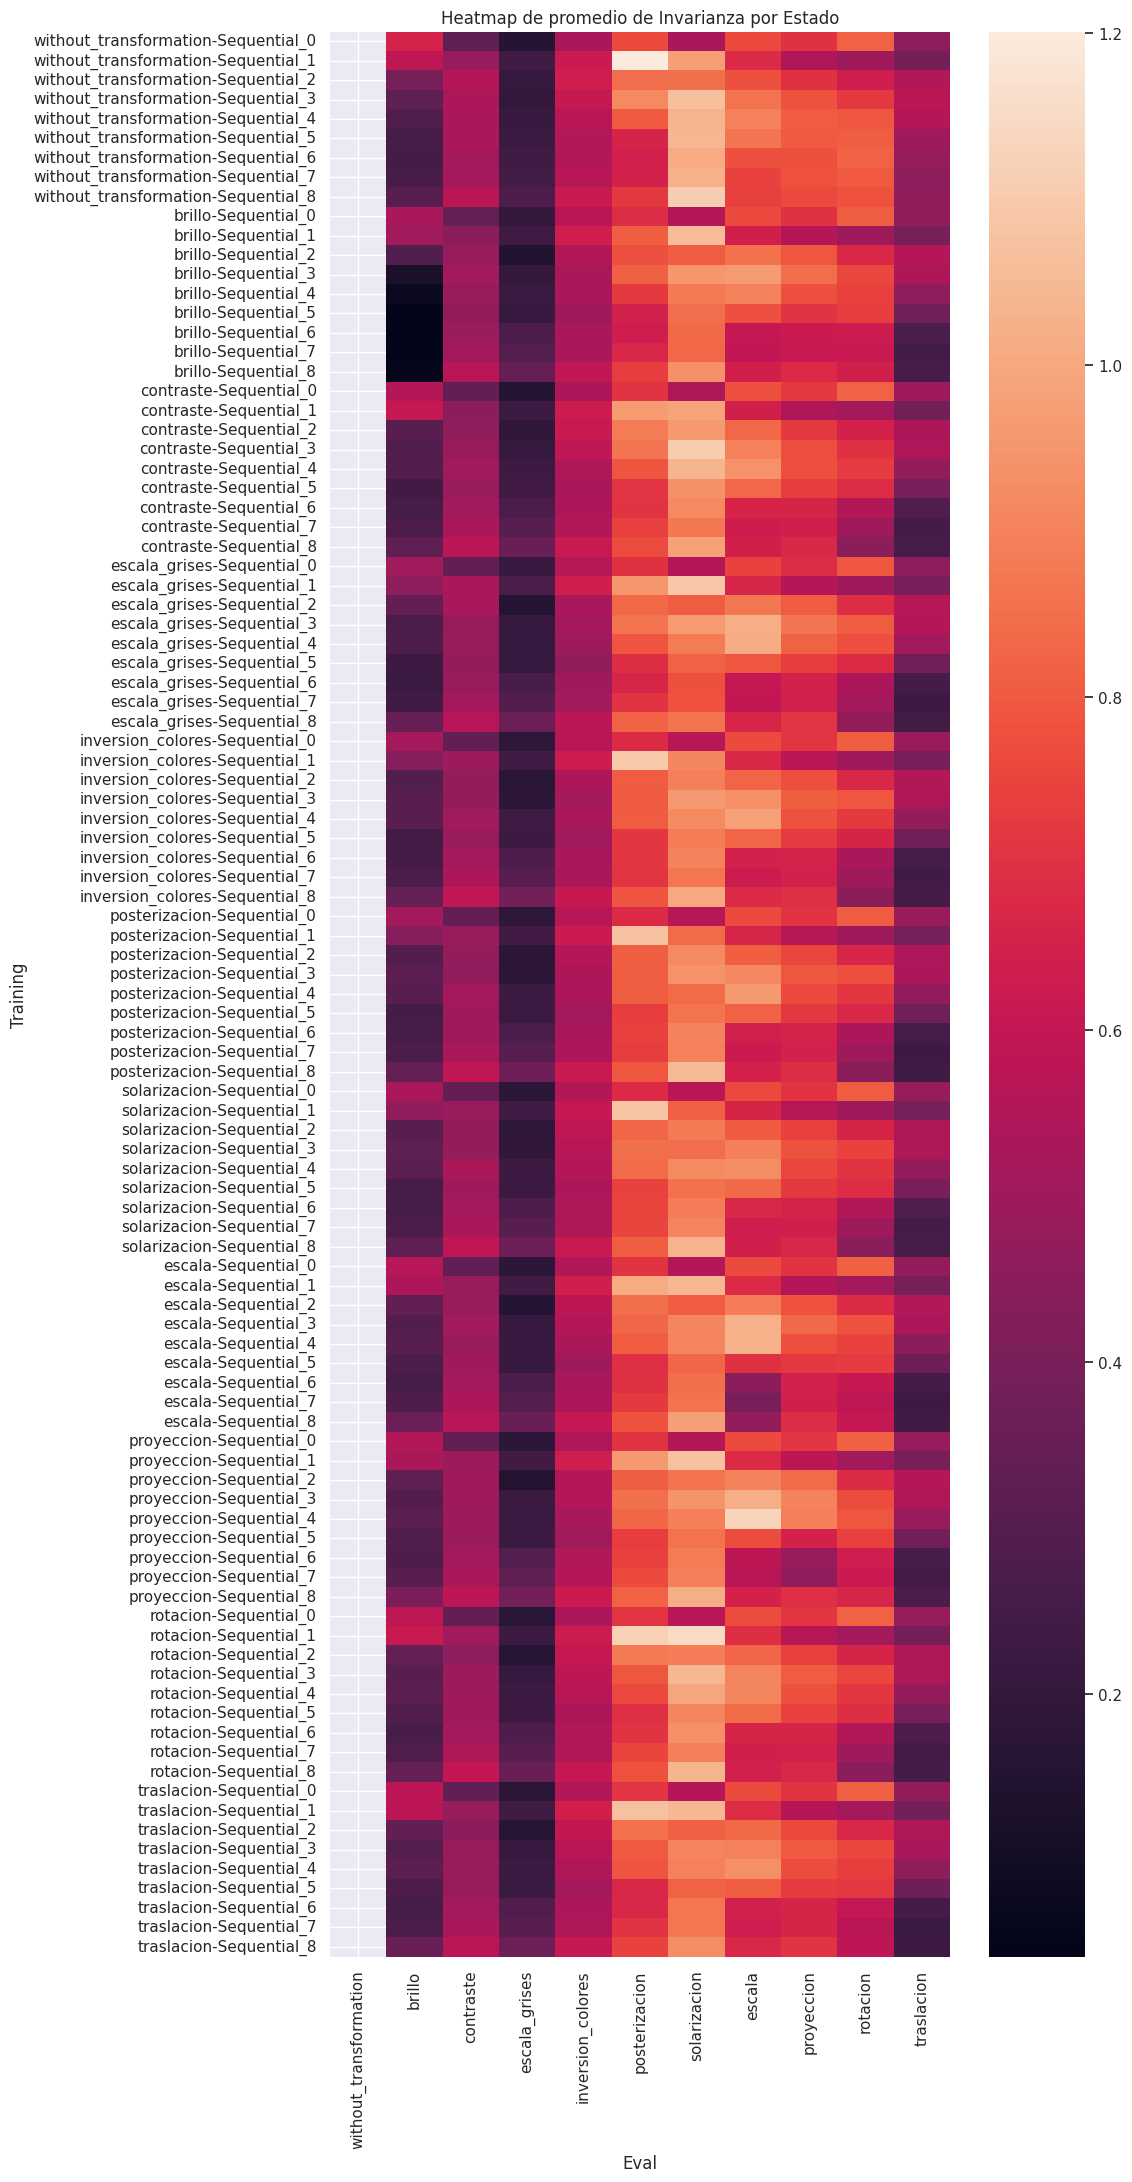

In [39]:
# Crear el mapa de colores
plt.figure(figsize=(10, 25))
sns.heatmap(df_pivot, annot=False, cbar=True)

plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

In [40]:
df_pivot2 = df_mean.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot2

/tmp/ipykernel_342545/3948128716.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot2 = df_mean.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')


Eval                      brillo  contraste  escala_grises  inversion_colores  \
Training                                                                        
without_transformation  0.370119   0.508792       0.223030           0.583050   
brillo                  0.189689   0.479301       0.238454           0.551943   
contraste               0.351471   0.481254       0.243107           0.571914   
escala_grises           0.321633   0.489653       0.244046           0.533126   
inversion_colores       0.330387   0.490632       0.245614           0.550776   
posterizacion           0.332975   0.487928       0.243622           0.556089   
solarizacion            0.339806   0.492813       0.245046           0.566867   
escala                  0.357465   0.490145       0.240698           0.559977   
proyeccion              0.365289   0.492351       0.250244           0.560500   
rotacion                0.372129   0.494089       0.241832           0.573553   
traslacion              0.362465   0.481910       0.242975           0.567734   

Eval                    posterizacion  solarizacion    escala  proyeccion  \
Training                                                                    
without_transformation       0.799975      0.958925  0.788283    0.739584   
brillo                       0.721804      0.855221  0.748281    0.699063   
contraste                    0.790794      0.926266  0.761138    0.694076   
escala_grises                0.778965      0.837673  0.774026    0.718659   
inversion_colores            0.789726      0.877126  0.773126    0.707508   
posterizacion                0.796783      0.867945  0.760476    0.699534   
solarizacion                 0.815113      0.855984  0.757546    0.692689   
escala                       0.788942      0.858815  0.710408    0.706485   
proyeccion                   0.799694      0.886028  0.784911    0.690641   
rotacion                     0.798438      0.934173  0.764432    0.702220   
traslacion                   0.779543      0.855888  0.763682    0.705546   

Eval                    rotacion  traslacion  
Training                                      
without_transformation  0.742425    0.494101  
brillo                  0.676791    0.396425  
contraste               0.620636    0.403362  
escala_grises           0.639885    0.398738  
inversion_colores       0.626189    0.397155  
posterizacion           0.622717    0.391037  
solarizacion            0.621456    0.403906  
escala                  0.674201    0.387321  
proyeccion              0.693149    0.403738  
rotacion                0.627265    0.400563  
traslacion              0.661415    0.383571

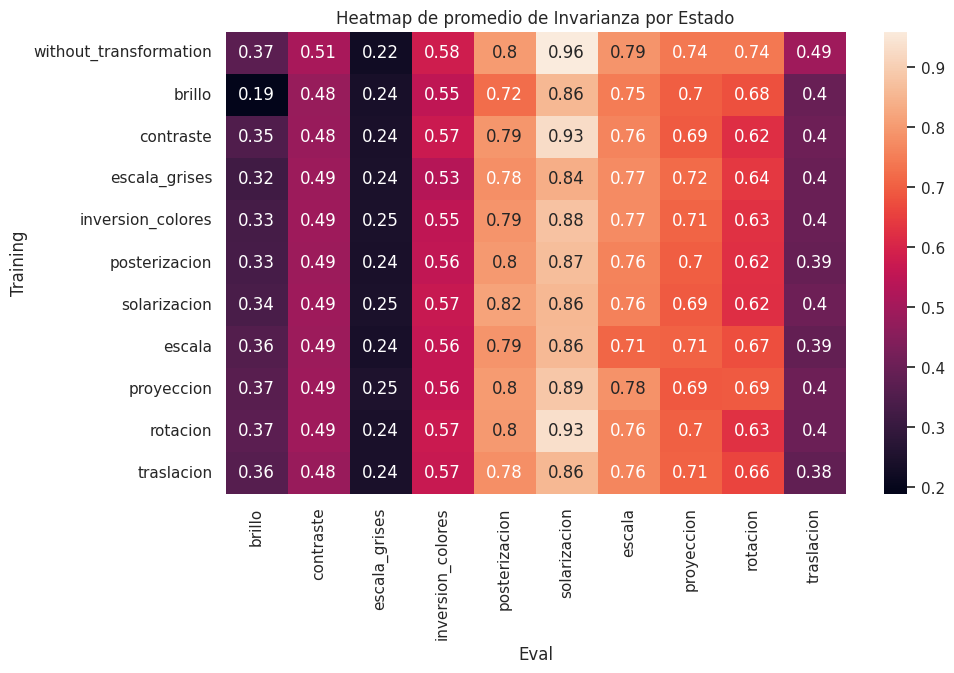

In [41]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot2, annot=True, cbar=True)

plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

In [ ]:
os.getcwd()

### Mismo analisis sin bloque SE

In [42]:
#  quito los bloques SE para analizar la invarianza sin esos bloques xq no son secuenciales
bloque_se = ['avgpool',
'fc1',
'activation',
'fc2',
'scale_activation']


In [43]:
df_complete.columns

Index(['layer_name', 'inv_avg', 'Sequential', '1', '2', '3', '4', 'layer',
       'Training', 'Eval', 'layer_num'],
      dtype='object')

In [44]:
df_without_se = df_complete.loc[~df_complete['4'].isin(bloque_se)]
df_without_se.shape

(14630, 11)

In [45]:
df_mean2 = df_without_se.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()

/tmp/ipykernel_342545/2686870587.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean2 = df_without_se.groupby(['Training', 'Eval','Sequential']).agg({'inv_avg':'mean'}).reset_index()


In [46]:
df_pivot3 = df_mean2.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot3

Eval                                 without_transformation    brillo  \
Training               Sequential                                       
without_transformation Sequential_0                     NaN  0.655907   
                       Sequential_1                     NaN  0.470571   
                       Sequential_2                     NaN  0.284603   
                       Sequential_3                     NaN  0.257312   
                       Sequential_4                     NaN  0.261441   
...                                                     ...       ...   
traslacion             Sequential_4                     NaN  0.221908   
                       Sequential_5                     NaN  0.200564   
                       Sequential_6                     NaN  0.234342   
                       Sequential_7                     NaN  0.270746   
                       Sequential_8                     NaN  0.357025   

Eval                                 contraste  escala_grises  \
Training               Sequential                               
without_transformation Sequential_0   0.331168       0.158520   
                       Sequential_1   0.389647       0.132926   
                       Sequential_2   0.419705       0.130540   
                       Sequential_3   0.442679       0.147483   
                       Sequential_4   0.455437       0.180244   
...                                        ...            ...   
traslacion             Sequential_4   0.416061       0.166555   
                       Sequential_5   0.418640       0.176906   
                       Sequential_6   0.467227       0.244712   
                       Sequential_7   0.512419       0.295547   
                       Sequential_8   0.570828       0.360377   

Eval                                 inversion_colores  posterizacion  \
Training               Sequential                                       
without_transformation Sequential_0           0.533155       0.758126   
                       Sequential_1           0.554875       0.679900   
                       Sequential_2           0.587568       0.636292   
                       Sequential_3           0.601213       0.629896   
                       Sequential_4           0.603395       0.611074   
...                                                ...            ...   
traslacion             Sequential_4           0.521806       0.569794   
                       Sequential_5           0.500161       0.527617   
                       Sequential_6           0.526592       0.592586   
                       Sequential_7           0.555800       0.648700   
                       Sequential_8           0.609791       0.739882   

Eval                                 solarizacion    escala  proyeccion  \
Training               Sequential                                         
without_transformation Sequential_0      0.529796  0.760140    0.700789   
                       Sequential_1      0.543155  0.873555    0.810337   
                       Sequential_2      0.592347  0.945207    0.894380   
                       Sequential_3      0.715698  0.987758    0.923496   
                       Sequential_4      0.790372  0.972819    0.891742   
...                                           ...       ...         ...   
traslacion             Sequential_4      0.692135  0.999771    0.849075   
                       Sequential_5      0.698974  0.868734    0.780484   
                       Sequential_6      0.795541  0.684098    0.689414   
                       Sequential_7      0.841543  0.648888    0.684788   
                       Sequential_8      0.936879  0.677569    0.709172   

Eval                                 rotacion  traslacion  
Training               Sequential                          
without_transformation Sequential_0  0.817618    0.457046  
                       Sequential_1  0.872496    0.653352  
                       Sequential_2  0

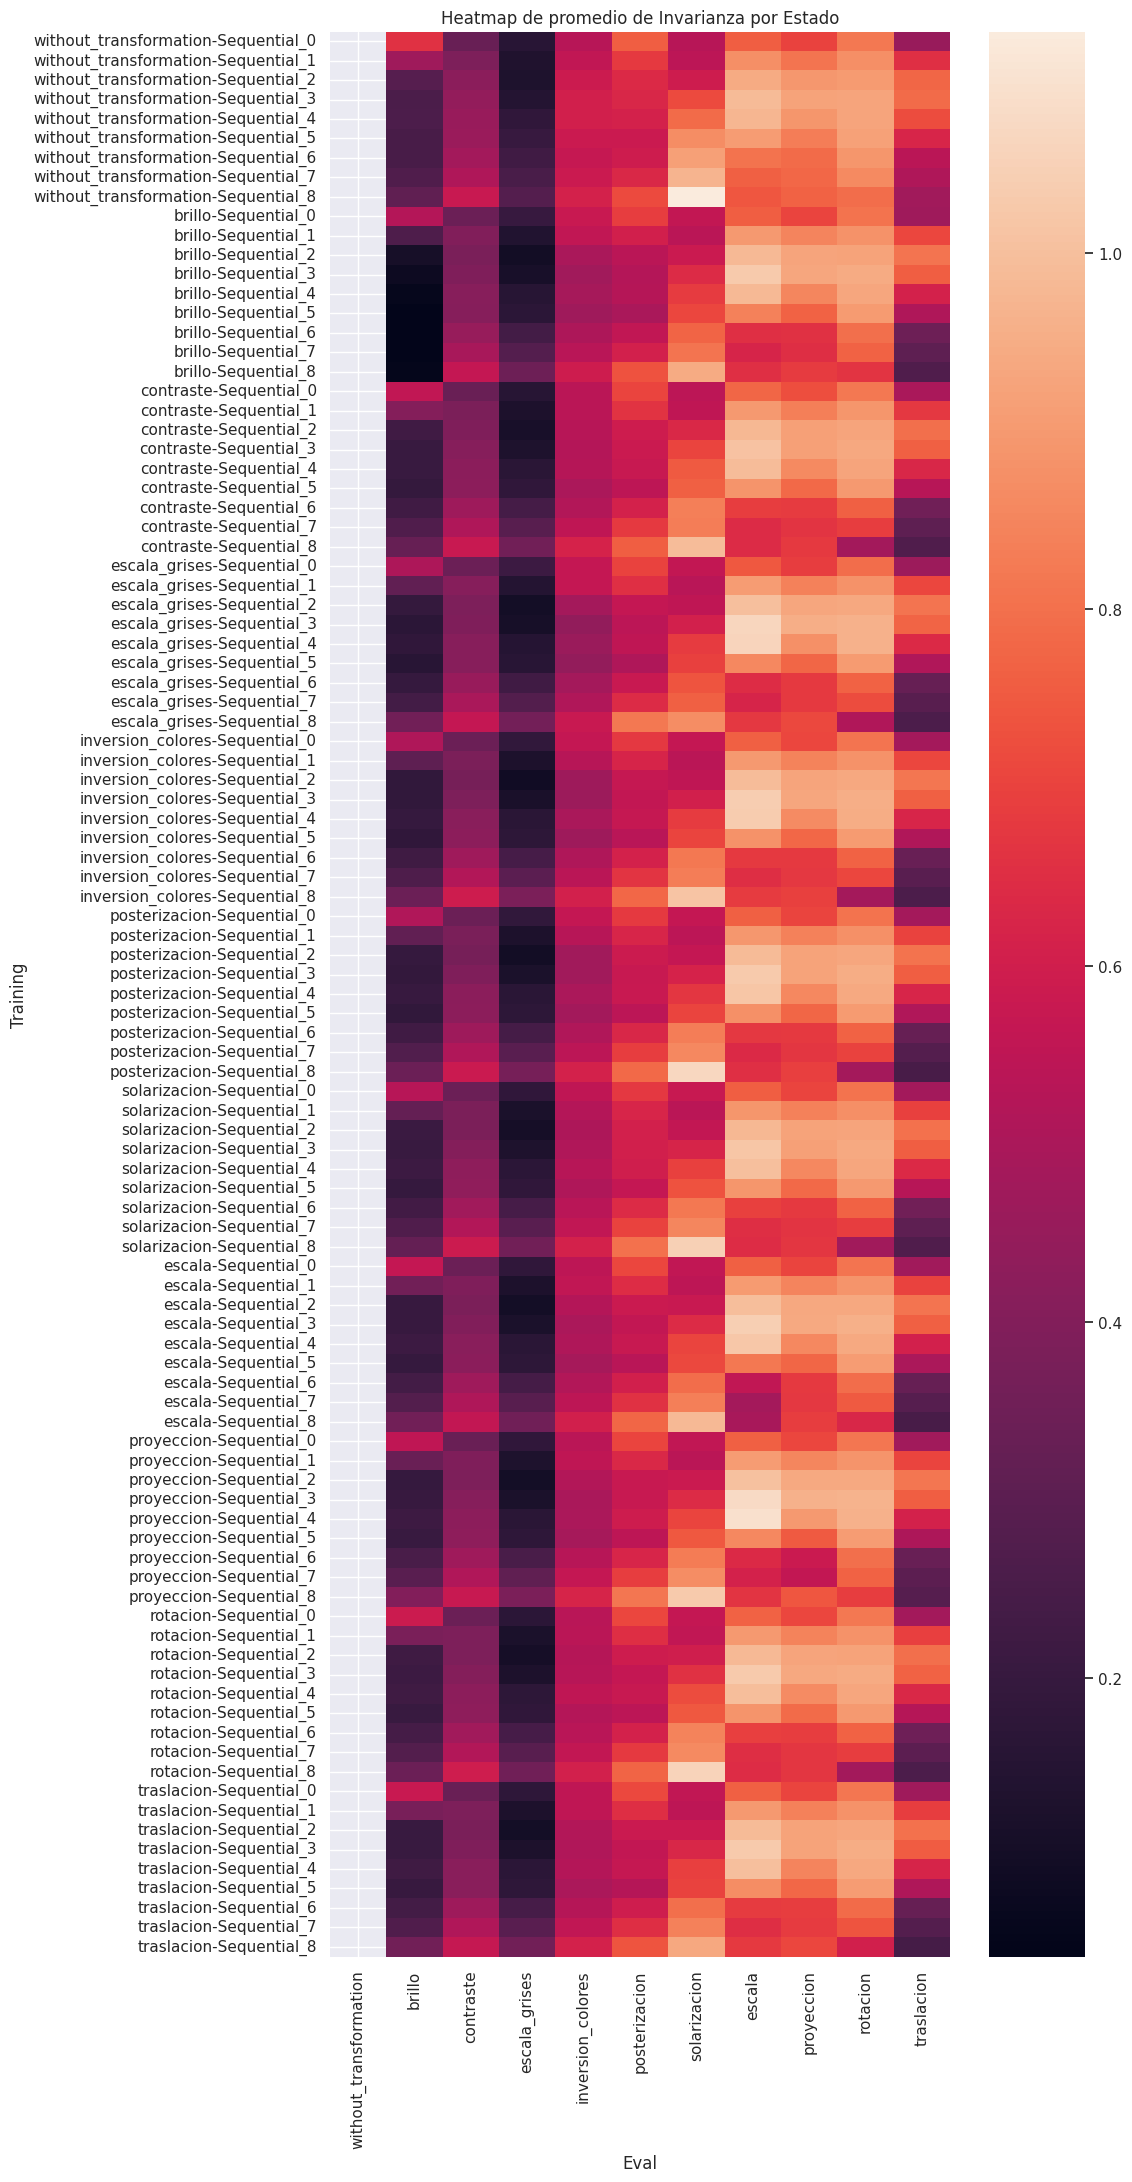

In [47]:
# Crear el mapa de colores
plt.figure(figsize=(10, 25))
sns.heatmap(df_pivot3, annot=False, cbar=True)

plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

In [48]:
df_pivot4 = df_mean2.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot4

/tmp/ipykernel_342545/898655856.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot4 = df_mean2.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')


Eval                      brillo  contraste  escala_grises  inversion_colores  \
Training                                                                        
without_transformation  0.334527   0.452445       0.190168           0.580898   
brillo                  0.136363   0.427190       0.193957           0.522579   
contraste               0.291487   0.436229       0.195542           0.538746   
escala_grises           0.257113   0.430942       0.194837           0.503495   
inversion_colores       0.266600   0.434838       0.198227           0.516868   
posterizacion           0.272098   0.433350       0.196219           0.522284   
solarizacion            0.279061   0.439979       0.198787           0.538265   
escala                  0.290200   0.432926       0.195322           0.533174   
proyeccion              0.295909   0.438370       0.202637           0.534990   
rotacion                0.299905   0.441140       0.196120           0.546637   
traslacion              0.294672   0.431579       0.196702           0.538678   

Eval                    posterizacion  solarizacion    escala  proyeccion  \
Training                                                                    
without_transformation       0.648731      0.783370  0.862257    0.820966   
brillo                       0.586348      0.694165  0.825162    0.780392   
contraste                    0.634594      0.734723  0.834827    0.784871   
escala_grises                0.618249      0.667710  0.841179    0.793367   
inversion_colores            0.620739      0.700924  0.846671    0.790083   
posterizacion                0.631072      0.713088  0.837196    0.785100   
solarizacion                 0.647102      0.715986  0.835721    0.782281   
escala                       0.626664      0.706112  0.786252    0.790012   
proyeccion                   0.638394      0.721811  0.845838    0.778154   
rotacion                     0.632745      0.733636  0.838630    0.788376   
traslacion                   0.620378      0.697771  0.839687    0.789656   

Eval                    rotacion  traslacion  
Training                                      
without_transformation  0.878968    0.616111  
brillo                  0.846929    0.532956  
contraste               0.814781    0.536124  
escala_grises           0.826457    0.531261  
inversion_colores       0.821142    0.533680  
posterizacion           0.817287    0.527306  
solarizacion            0.811859    0.537264  
escala                  0.845946    0.524245  
proyeccion              0.858870    0.533400  
rotacion                0.815096    0.534261  
traslacion              0.839143    0.522442

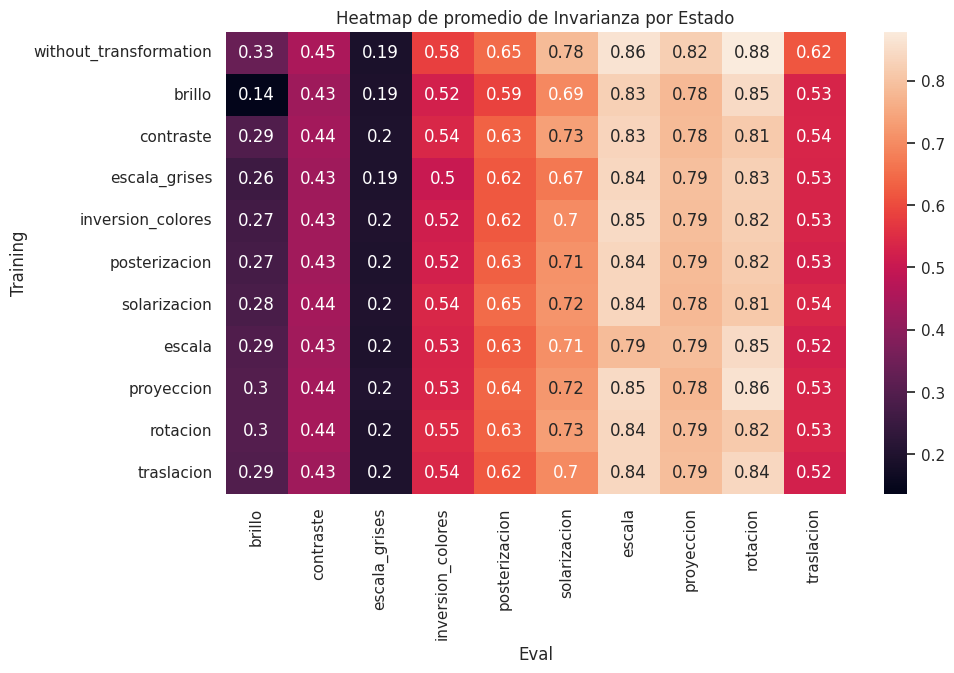

In [49]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot4, annot=True, cbar=True)

plt.title('Heatmap de promedio de Invarianza por Estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

### Mismo analisis de la salida de cada bloque

In [50]:
# Función para extraer el sufijo numérico
def extract_numeric_suffix(layer):
    match = re.search(r'_(\d+)$', layer)
    return int(match.group(1)) if match else -1

# Crear una nueva columna con el sufijo numérico
df_complete['layer_num'] = df_complete['layer'].apply(extract_numeric_suffix)

# Ordenar el DataFrame por 'Training', 'Eval', 'Sequential' y 'layer_num'
df_sorted = df_complete.sort_values(by=['Training', 'Eval', 'Sequential', 'layer_num'], ascending=[True, True, True, False])

# Obtener la capa con el valor más grande en el sufijo dentro de cada grupo
df_max_layer = df_sorted.groupby(['Training', 'Eval', 'Sequential']).first().reset_index()

# Eliminar la columna auxiliar 'layer_num' si ya no es necesaria
df_max_layer = df_max_layer.drop(columns=['layer_num'])

# Mostrar el DataFrame con la capa de mayor valor en el sufijo por grupo
df_max_layer

/tmp/ipykernel_342545/2492696179.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_max_layer = df_sorted.groupby(['Training', 'Eval', 'Sequential']).first().reset_index()


Training                    Eval    Sequential  \
0     without_transformation  without_transformation  Sequential_0   
1     without_transformation  without_transformation  Sequential_1   
2     without_transformation  without_transformation  Sequential_2   
3     without_transformation  without_transformation  Sequential_3   
4     without_transformation  without_transformation  Sequential_4   
...                      ...                     ...           ...   
1084              traslacion              traslacion  Sequential_4   
1085              traslacion              traslacion  Sequential_5   
1086              traslacion              traslacion  Sequential_6   
1087              traslacion              traslacion  Sequential_7   
1088              traslacion              traslacion  Sequential_8   

                                             layer_name   inv_avg         1  \
0                                                   NaN       NaN       NaN   
1                                                   NaN       NaN       NaN   
2                                                   NaN       NaN       NaN   
3                                                   NaN       NaN       NaN   
4                                                   NaN       NaN       NaN   
...                                                 ...       ...       ...   
1084  Sequential_4/MBConv_2/block/Conv2dNormActivati...  0.680547  MBConv_2   
1085  Sequential_5/MBConv_2/block/Conv2dNormActivati...  0.551523  MBConv_2   
1086  Sequential_6/MBConv_3/block/Conv2dNormActivati...  0.348007  MBConv_3   
1087  Sequential_7/MBConv_0/block/Conv2dNormActivati...  0.302341  MBConv_0   
1088                                classifier/Linear_1  0.218968      None   

          2                       3              4            layer  
0       NaN                     NaN            NaN              NaN  
1       NaN                     NaN            NaN              NaN  
2       NaN                     NaN            NaN              NaN  
3       NaN                     NaN            NaN              NaN  
4       NaN                     NaN            NaN              NaN  
...     ...                     ...            ...              ...  
1084  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_103  
1085  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_142  
1086  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_194  
1087  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_207  
1088   None              classifier       Linear_1       Linear_213  

[1089 rows x 10 columns]

In [51]:
df_max_layer.loc[(df_max_layer.Training == 'brillo') & (df_max_layer.Eval == 'brillo') ]

Training    Eval    Sequential  \
108   brillo  brillo  Sequential_0   
109   brillo  brillo  Sequential_1   
110   brillo  brillo  Sequential_2   
111   brillo  brillo  Sequential_3   
112   brillo  brillo  Sequential_4   
113   brillo  brillo  Sequential_5   
114   brillo  brillo  Sequential_6   
115   brillo  brillo  Sequential_7   
116   brillo  brillo  Sequential_8   

                                            layer_name   inv_avg         1  \
108                      Conv2dNormActivation_0/SiLU_2  0.523915      None   
109  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.173902  MBConv_0   
110  Sequential_2/MBConv_1/block/Conv2dNormActivati...  0.097420  MBConv_1   
111  Sequential_3/MBConv_1/block/Conv2dNormActivati...  0.077316  MBConv_1   
112  Sequential_4/MBConv_2/block/Conv2dNormActivati...  0.064045  MBConv_2   
113  Sequential_5/MBConv_2/block/Conv2dNormActivati...  0.052750  MBConv_2   
114  Sequential_6/MBConv_3/block/Conv2dNormActivati...  0.050283  MBConv_3   
115  Sequential_7/MBConv_0/block/Conv2dNormActivati...  0.057512  MBConv_0   
116                                classifier/Linear_1  0.061508      None   

         2                       3              4            layer  
108   None  Conv2dNormActivation_0         SiLU_2           SiLU_2  
109  block  Conv2dNormActivation_2  BatchNorm2d_1   BatchNorm2d_12  
110  block  Conv2dNormActivation_3  BatchNorm2d_1   BatchNorm2d_38  
111  block  Conv2dNormActivation_3  BatchNorm2d_1   BatchNorm2d_64  
112  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_103  
113  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_142  
114  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_194  
115  block  Conv2dNormActivation_3  BatchNorm2d_1  BatchNorm2d_207  
116   None              classifier       Linear_1       Linear_213

In [52]:
df_pivot5 = df_max_layer.pivot(index=['Training', 'Sequential'], columns=["Eval"], values="inv_avg")
df_pivot5

Eval                                 without_transformation    brillo  \
Training               Sequential                                       
without_transformation Sequential_0                     NaN  0.662298   
                       Sequential_1                     NaN  0.361540   
                       Sequential_2                     NaN  0.273830   
                       Sequential_3                     NaN  0.271549   
                       Sequential_4                     NaN  0.281251   
...                                                     ...       ...   
traslacion             Sequential_4                     NaN  0.238654   
                       Sequential_5                     NaN  0.219111   
                       Sequential_6                     NaN  0.273430   
                       Sequential_7                     NaN  0.348720   
                       Sequential_8                     NaN  0.504102   

Eval                                 contraste  escala_grises  \
Training               Sequential                               
without_transformation Sequential_0   0.328400       0.155543   
                       Sequential_1   0.424267       0.139137   
                       Sequential_2   0.456611       0.138095   
                       Sequential_3   0.472387       0.165909   
                       Sequential_4   0.487144       0.202705   
...                                        ...            ...   
traslacion             Sequential_4   0.443110       0.185403   
                       Sequential_5   0.458173       0.201269   
                       Sequential_6   0.526718       0.297623   
                       Sequential_7   0.600294       0.386330   
                       Sequential_8   0.643788       0.407830   

Eval                                 inversion_colores  posterizacion  \
Training               Sequential                                       
without_transformation Sequential_0           0.527348       0.762952   
                       Sequential_1           0.634735       0.684731   
                       Sequential_2           0.620104       0.677149   
                       Sequential_3           0.636904       0.658643   
                       Sequential_4           0.641912       0.637757   
...                                                ...            ...   
traslacion             Sequential_4           0.557721       0.590049   
                       Sequential_5           0.547647       0.566122   
                       Sequential_6           0.583544       0.653072   
                       Sequential_7           0.643555       0.750786   
                       Sequential_8           0.660372       0.861843   

Eval                                 solarizacion    escala  proyeccion  \
Training               Sequential                                         
without_transformation Sequential_0      0.458330  0.751549    0.693279   
                       Sequential_1      0.646527  0.941101    0.850960   
                       Sequential_2      0.744457  1.017050    0.960992   
                       Sequential_3      0.866094  1.035744    0.950161   
                       Sequential_4      0.938114  1.006690    0.917551   
...                                           ...       ...         ...   
traslacion             Sequential_4      0.831134  1.065862    0.892732   
                       Sequential_5      0.846727  0.899054    0.810120   
                       Sequential_6      0.926671  0.710876    0.735692   
                       Sequential_7      0.939448  0.702031    0.741498   
                       Sequential_8      1.216315  0.851117    0.818735   

Eval                                 rotacion  traslacion  
Training               Sequential                          
without_transformation Sequential_0  0.809040    0.452171  
                       Sequential_1  0.914532    0.741155  
                       Sequential_2  0

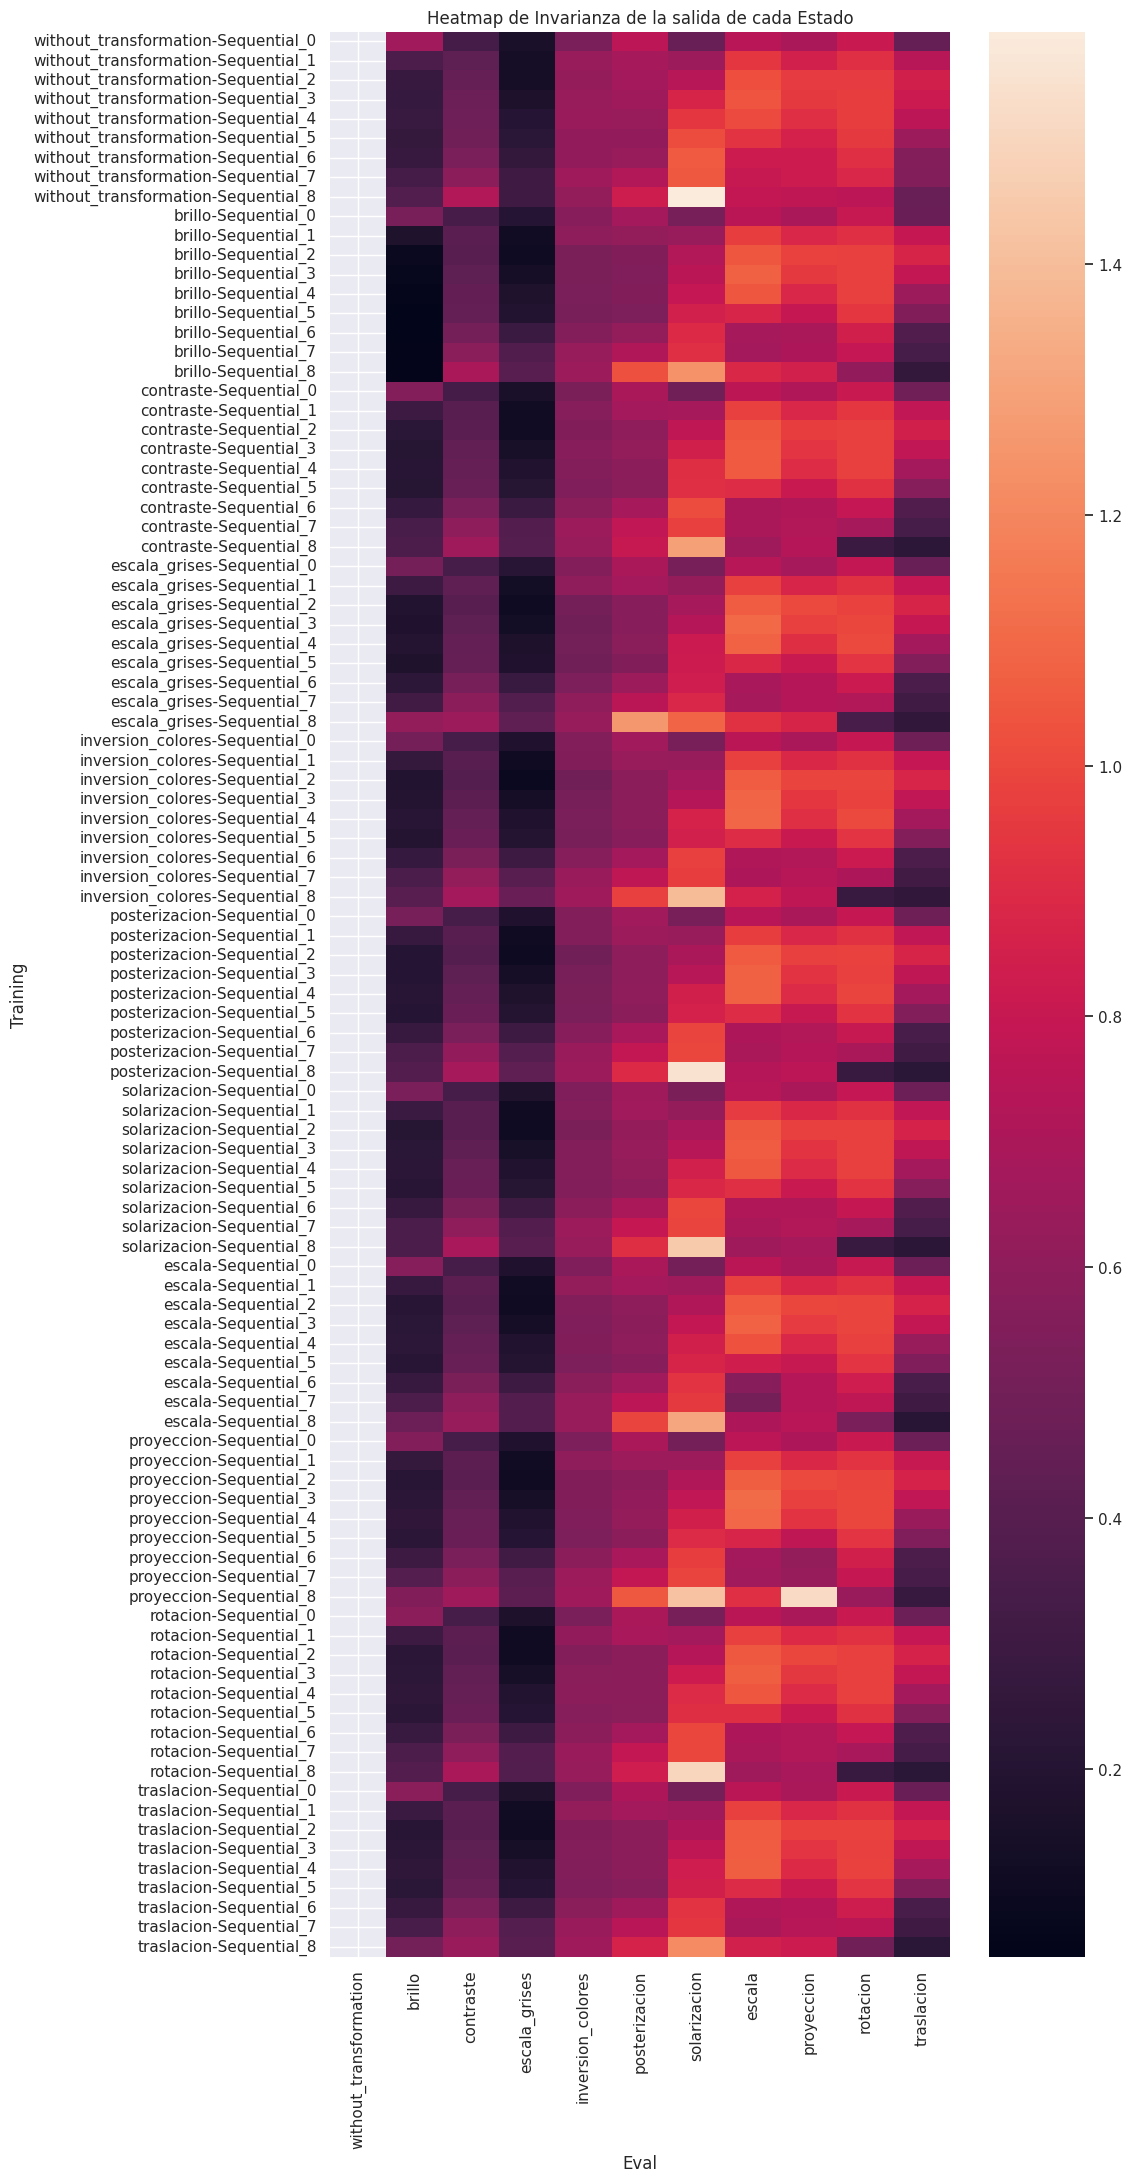

In [53]:
# Crear el mapa de colores
plt.figure(figsize=(10, 25))
sns.heatmap(df_pivot5, annot=False, cbar=True)

plt.title('Heatmap de Invarianza de la salida de cada Estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

In [54]:
df_pivot6 = df_max_layer.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')
df_pivot6

/tmp/ipykernel_342545/3621087520.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot6 = df_max_layer.pivot_table(index=['Training'], columns='Eval', values='inv_avg', aggfunc='mean')


Eval                      brillo  contraste  escala_grises  inversion_colores  \
Training                                                                        
without_transformation  0.343812   0.499847       0.210014           0.617943   
brillo                  0.128739   0.473814       0.220906           0.567968   
contraste               0.299486   0.476462       0.221083           0.577927   
escala_grises           0.301760   0.472878       0.223496           0.549290   
inversion_colores       0.289874   0.477054       0.229877           0.559121   
posterizacion           0.292708   0.476115       0.224386           0.562180   
solarizacion            0.295893   0.482117       0.224529           0.577241   
escala                  0.315601   0.473253       0.221785           0.578545   
proyeccion              0.330133   0.479914       0.230956           0.580774   
rotacion                0.314235   0.484322       0.221437           0.589124   
traslacion              0.321567   0.472185       0.225150           0.586049   

Eval                    posterizacion  solarizacion    escala  proyeccion  \
Training                                                                    
without_transformation       0.690991      0.928365  0.898930    0.849019   
brillo                       0.647806      0.814237  0.887556    0.829003   
contraste                    0.670213      0.875919  0.873657    0.820365   
escala_grises                0.702930      0.777928  0.903396    0.842951   
inversion_colores            0.673514      0.843896  0.904527    0.831522   
posterizacion                0.674139      0.870107  0.883534    0.824271   
solarizacion                 0.689531      0.861485  0.872751    0.813086   
escala                       0.683567      0.841590  0.835474    0.826553   
proyeccion                   0.698680      0.863084  0.903761    0.892938   
rotacion                     0.669860      0.894556  0.874773    0.819650   
traslacion                   0.664371      0.823385  0.896818    0.833319   

Eval                    rotacion  traslacion  
Training                                      
without_transformation  0.901186    0.648321  
brillo                  0.869466    0.564065  
contraste               0.817216    0.564162  
escala_grises           0.834066    0.563181  
inversion_colores       0.825595    0.564938  
posterizacion           0.820741    0.556151  
solarizacion            0.813677    0.563465  
escala                  0.860321    0.551306  
proyeccion              0.881102    0.564011  
rotacion                0.816752    0.562156  
traslacion              0.854394    0.553906

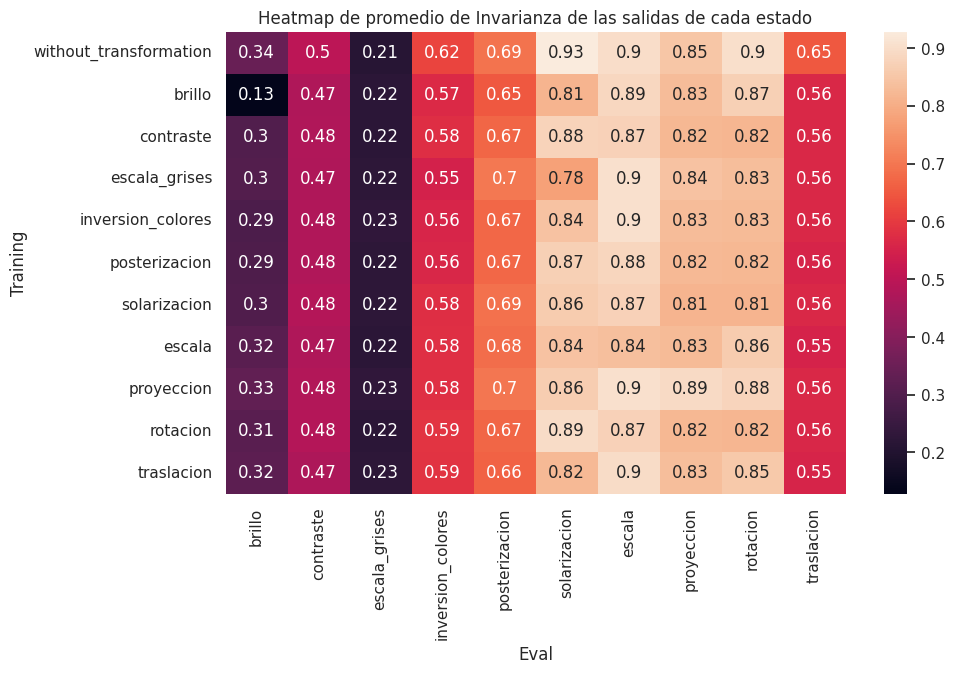

In [55]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot6, annot=True, cbar=True)

plt.title('Heatmap de promedio de Invarianza de las salidas de cada estado')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()

## Accuracy Training Set

In [56]:
df_acc = pd.read_csv('/home/tbadaracco/models/efficientnet_b0/weights_none/performance_metrics_final_training.csv')

In [57]:
df_acc

Transformation_training  Accuracy_Train  Loss_Train  Precision_Train  \
0                proyeccion        0.518450    2.602824         0.571517   
1                 contraste        0.888520    0.407397         0.889951   
2                 contraste        0.838045    1.151487         0.840293   
3                 contraste        0.710903    4.567888         0.744191   
4                 contraste        0.600267    9.687851         0.664359   
..                      ...             ...         ...              ...   
105           posterizacion        0.590000   21.790000         0.700000   
106           posterizacion        0.610000   23.110000         0.700000   
107           posterizacion        0.570000  800.160000         0.660000   
108           posterizacion        0.550000  806.930000         0.650000   
109           posterizacion        0.500000  816.600000         0.630000   

     Recall_Train Transformation_eval  Unnamed: 0  epoch  
0        0.518450            rotacion         NaN    NaN  
1        0.888520            rotacion         NaN    NaN  
2        0.838045          traslacion         NaN    NaN  
3        0.710903              escala         NaN    NaN  
4        0.600267          proyeccion         NaN    NaN  
..            ...                 ...         ...    ...  
105      0.590000           contraste       104.0  104.0  
106      0.610000       escala_grises       105.0  105.0  
107      0.570000        solarizacion       106.0  106.0  
108      0.550000       posterizacion       107.0  107.0  
109      0.500000   inversion_colores       108.0  108.0  

[110 rows x 8 columns]

In [58]:
order_transformation = CategoricalDtype(
    ['without_transformation','brillo', 'contraste', 'escala_grises','inversion_colores', 'posterizacion','solarizacion', 'escala','proyeccion', 'rotacion', 'traslacion'],
    ordered=True
)

# Convertir columnas al tipo categórico
df_complete['Training'] = df_complete['Training'].astype(order_transformation)
df_complete['Eval'] = df_complete['Eval'].astype(order_transformation)
df_complete.sort_values(by = ['Training','Eval','Sequential', 'layer_num'], ascending=[True, True, True, True],inplace=True)
df_complete

layer_name   inv_avg  \
19902                    Conv2dNormActivation_0/Conv2d_0  0.643125   
19903               Conv2dNormActivation_0/BatchNorm2d_1  0.662298   
19904                      Conv2dNormActivation_0/SiLU_2  0.662298   
19905  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.544358   
19906  Sequential_1/MBConv_0/block/Conv2dNormActivati...  0.542709   
...                                                  ...       ...   
4275                Conv2dNormActivation_8/BatchNorm2d_1  0.262432   
4276                       Conv2dNormActivation_8/SiLU_2  0.262432   
4277                                             avgpool  0.167111   
4278                                classifier/Dropout_0  0.167111   
4279                                 classifier/Linear_1  0.218968   

         Sequential         1      2                       3              4  \
19902  Sequential_0       NaN    NaN  Conv2dNormActivation_0       Conv2d_0   
19903  Sequential_0       NaN    NaN  Conv2dNormActivation_0  BatchNorm2d_1   
19904  Sequential_0       NaN    NaN  Conv2dNormActivation_0         SiLU_2   
19905  Sequential_1  MBConv_0  block  Conv2dNormActivation_0       Conv2d_0   
19906  Sequential_1  MBConv_0  block  Conv2dNormActivation_0  BatchNorm2d_1   
...             ...       ...    ...                     ...            ...   
4275   Sequential_8       NaN    NaN  Conv2dNormActivation_8  BatchNorm2d_1   
4276   Sequential_8       NaN    NaN  Conv2dNormActivation_8         SiLU_2   
4277   Sequential_8       NaN    NaN          pre-classifier        avgpool   
4278   Sequential_8       NaN    NaN              classifier      Dropout_0   
4279   Sequential_8       NaN    NaN              classifier       Linear_1   

                 layer                Training        Eval  layer_num  
19902         Conv2d_0  without_transformation      brillo          0  
19903    BatchNorm2d_1  without_transformation      brillo          1  
19904           SiLU_2  without_transformation      brillo          2  
19905         Conv2d_3  without_transformation      brillo          3  
19906    BatchNorm2d_4  without_transformation      brillo          4  
...                ...                     ...         ...        ...  
4275   BatchNorm2d_209              traslacion  traslacion        209  
4276          SiLU_210              traslacion  traslacion        210  
4277       avgpool_211              traslacion  traslacion        211  
4278       Dropout_212              traslacion  traslacion        212  
4279        Linear_213              traslacion  traslacion        213  

[23540 rows x 11 columns]

In [59]:
df_acc.head()

Transformation_training  Accuracy_Train  Loss_Train  Precision_Train  \
0              proyeccion        0.518450    2.602824         0.571517   
1               contraste        0.888520    0.407397         0.889951   
2               contraste        0.838045    1.151487         0.840293   
3               contraste        0.710903    4.567888         0.744191   
4               contraste        0.600267    9.687851         0.664359   

   Recall_Train Transformation_eval  Unnamed: 0  epoch  
0      0.518450            rotacion         NaN    NaN  
1      0.888520            rotacion         NaN    NaN  
2      0.838045          traslacion         NaN    NaN  
3      0.710903              escala         NaN    NaN  
4      0.600267          proyeccion         NaN    NaN

In [60]:
df_acc_pivot = df_acc.pivot(index=['Transformation_training'], columns=["Transformation_eval"], values="Accuracy_Train")

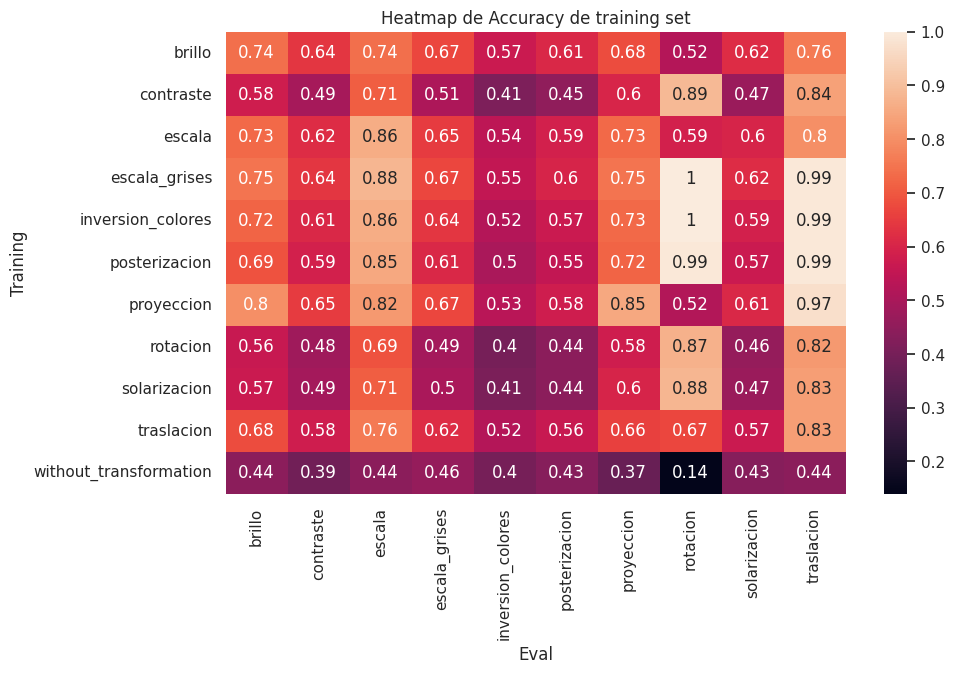

In [61]:
# Crear el mapa de colores
plt.figure(figsize=(10, 6))
sns.heatmap(df_acc_pivot, annot=True, cbar=True)

plt.title('Heatmap de Accuracy de training set')
plt.xlabel('Eval')
plt.ylabel('Training')
plt.show()